(geopandas2)=
# Geometric operations

In [56]:
!echo Last updated: `date +'%Y-%m-%d %H:%M:%S'`

Last updated: 2025-01-15 17:34:18


In [57]:
import options

*****

## Introduction

In the previous chapter we introduced the `geopandas` package, focusing on non-spatial operations such as subsetting by attributes (see {ref}`subsetting-by-attributes`), as well as geometry-related transformations (see {ref}`point-layer-from-table` and {ref}`geopandas-points-to-line`).

In this chapter, we go further into operations that involve the geometric component of one or more `GeoDataFrame`s, using the `geopandas` package. This group of operations includes the following standard spatial analysis functions:

* {ref}`geopandas-reprojection`—Transforming a given layer from one CRS to another
* {ref}`geopandas-numeric-calculations`—Calculating numeric geometry properties, such as length, area, and distance
* {ref}`geopandas-new-geometries-1`, {ref}`geopandas-new-geometries-2`—Creating new geometries, such as calculating buffers, or areas of intersection
* {ref}`geopandas-geometric-relations`—Evaluating the relation between layers, such as whether their geometries intersect
* {ref}`geopandas-spatial-join`—Joining attributes from one layer to another, based on spatial relations

By the end of this chapter, you will have an overview of all common worflows in spatial analysis of vector layers.

(geopandas2-sample-data)=
## Sample data

### Overview

First, let's prepare the environment to demostrate geometric operations using `geopandas`. First, we load the `pandas` and `geopandas` packages:

In [58]:
import pandas as pd
import geopandas as gpd

Next, let's load three layers, subset the relevant columns, and examine them visually. The first two (`towns` and `rail`) are familiar from the previous chapter (see {ref}`reading-vector-layers`), while the third one (`stations`) is new:

* `towns`—A polygonal layer of towns (see {ref}`towns-layer`)
* `rail`—A line layer of railway lines (see {ref}`rail-layer`)
* `stations`—A point layer of railway stations (see {ref}`stations-layer`)

(towns-layer)=
### Towns

The polygonal towns layer is imported from the Shapefile named `'muni_il.shp'`. Then we select the attributes of interest, plus the `'geometry'` column: 

In [59]:
towns = gpd.read_file('data/muni_il.shp', encoding='utf-8')
towns = towns[['Muni_Heb', 'Machoz', 'Shape_Area', 'geometry']]
towns

Muni_Heb   Machoz    Shape_Area  \
0                       שפיר     דרום  2.721176e+07   
1                     דימונה     דרום  7.708050e+04   
2                     דימונה     דרום  1.043253e+06   
3                     זבולון     חיפה  4.769053e+04   
4                      מגידו     צפון  2.144091e+04   
..                       ...      ...           ...   
406  ללא שיפוט - אזור מעיליא     צפון  2.001376e+05   
407                   זבולון     חיפה  2.246316e+05   
408                   זבולון     חיפה  1.141930e+06   
409                רמת השרון  תל אביב  4.076764e+04   
410                 צור הדסה  ירושלים  3.961142e+06   

                               geometry  
0    POLYGON Z ((177281.694 610056.5...  
1    POLYGON Z ((205753.745 560693.6...  
2    POLYGON Z ((207740.171 563476.5...  
3    POLYGON Z ((209445.229 740507.2...  
4    POLYGON Z ((206769.626 727131.7...  
..                                  ...  
406  POLYGON Z ((225369.655 770523.6...  
407  POLYGON Z ((207596.214 746263.0...  
408  POLYGON Z ((208622.688 746540.1...  
409  POLYGON Z ((183576.756 673627.0...  
410  POLYGON Z ((209871.005 625364.9...  

[411 rows x 4 columns]

Here is the towns layer, colored by the `'Machoz'` administrative division:

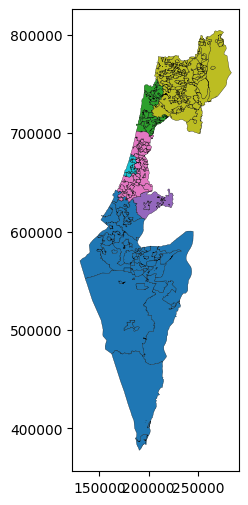

In [60]:
towns.plot(column='Machoz', edgecolor='black', linewidth=0.2);

(rail-layer)=
### Railway lines

Next, we read the railway line layer, from the Shapefile named `'RAIL_STRATEGIC.shp'`. We subset the layer by attributes (see {ref}`subsetting-by-attributes`) to retain just the active railway segments. Then, we subset just the `'SEGMENT'` (segment name) and `'geometry'` columns: 

In [61]:
rail = gpd.read_file('data/RAIL_STRATEGIC.shp')
rail = rail[rail['ISACTIVE'] == 'פעיל']
rail = rail[['SEGMENT', 'geometry']]
rail

SEGMENT                            geometry
0             כפר יהושע - נשר_1  LINESTRING (205530.083 741562.9...
1            באר יעקב-ראשונים_2  LINESTRING (181507.598 650706.1...
3         לב המפרץ מזרח - נשר_4  LINESTRING (203482.789 744181.5...
4             קרית גת - להבים_5  LINESTRING (178574.101 609392.9...
5            רמלה - רמלה מזרח_6  LINESTRING (189266.58 647211.50...
..                          ...                                 ...
210           ויתקין - חדרה_215  LINESTRING (190758.23 704950.04...
211  בית יהושע - נתניה ספיר_216  LINESTRING (187526.597 687360.3...
214       השמונה - בית המכס_220  LINESTRING (200874.999 746209.3...
215     לב המפרץ - בית המכס_221  LINESTRING (203769.786 744358.6...
216         224_לוד מרכז - נתבג  LINESTRING (190553.481 654170.3...

[161 rows x 2 columns]

Here is a plot of the `rail` layer, colored by segment name:

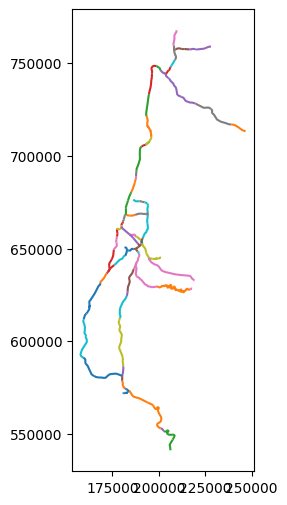

In [62]:
rail.plot(column='SEGMENT');

(stations-layer)=
### Railway stations

Finally, we read a layer of rainway *stations*, from a Shapefile named `'RAIL_STAT_ONOFF_MONTH.shp'`. The attributes of interest which we retain (in addition to the `'geometry'`) are:

* `'STAT_NAMEH'`—Station name
* `'OFF_7_DAY'`—Passengers exiting the station at 7:00-8:00 during September 2020
<!-- * `'ON_7_DAY'`—Passengers entering the station at 7:00-8:00 during September 2020 -->
<!-- * `'ON_17_DAY'`—Passengers entering the station at 17:00-18:00 during September 2020 -->
<!-- * `'OFF_17_DAY'`—Passengers exiting the station at 17:00-18:00 during September 2020 -->

In [63]:
stations = gpd.read_file('data/RAIL_STAT_ONOFF_MONTH.shp')
stations = stations[['STAT_NAMEH', 'OFF_7_DAY', 'geometry']]
stations

STAT_NAMEH  OFF_7_DAY                       geometry
0   ראשון לציון משה דיין       72.0  POINT (177206.094 655059.936)
1        קרית ספיר נתניה      119.0  POINT (187592.123 687587.598)
2              ת"א השלום     1642.0    POINT (180621.94 664537.21)
3                  שדרות       26.0  POINT (160722.849 602798.889)
4                   רמלה       47.0    POINT (188508.91 648466.87)
..                   ...        ...                            ...
58    מגדל העמק כפר ברוך        5.0  POINT (219851.931 728164.825)
59    באר שבע אוניברסיטה      130.0  POINT (181813.614 574550.411)
60          חיפה בת גלים      311.0    POINT (198610.01 748443.79)
61                   לוד      238.0  POINT (188315.977 650289.373)
62                 נהריה       64.0    POINT (209570.59 767769.22)

[63 rows x 3 columns]

Here is a visualization of the `stations` layer. Using symbology, we demonstrate that the largest number of passengers exiting a station in 7:00-8:00 are in Tel-Aviv, where lots of people travel to work:

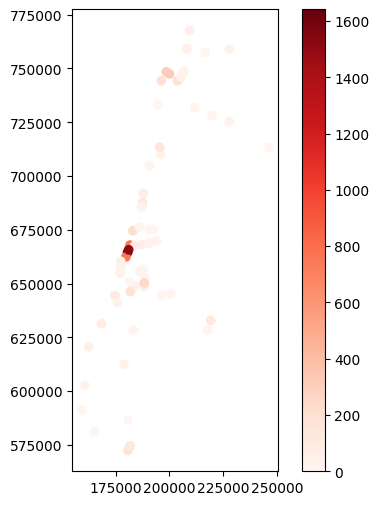

In [64]:
stations.plot(column='OFF_7_DAY', cmap='Reds', legend=True);

Here is the plot of the `towns`, `stations`, and `rail` layers, together (see {ref}`geopandas-plotting-more-than-one-layer`):

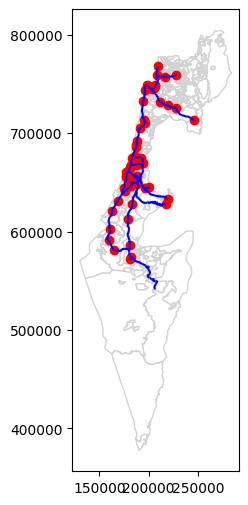

In [65]:
base = towns.plot(color='white', edgecolor='lightgrey')
stations.plot(ax=base, color='red')
rail.plot(ax=base, color='blue');

(geopandas-reprojection)=
## CRS and reprojection

(what-is-a-crs)=
### What is a CRS?

A Coordinate Reference System (CRS) defines the association between coordinates (which are ultimately just numbers) and specific locations on the surface of the earth. CRS can be divided into two groups:

* Geographic CRS, where units are degrees (e.g., [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System))
* Projected CRS, where units are "real" distance units, typically meters (e.g., [ITM](https://en.wikipedia.org/wiki/Israeli_Transverse_Mercator), [UTM](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system))

There are several methods and formats to describe and specify a CRS. The shortest and simplest method is to use an [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) code, which all standard CRS have. For example, {numref}`crs` specifies the EPSG codes of CRS we encounter in this book.

```{table} Coordinate Reference Systems (CRS) used in this book
:name: crs

| Name | Type | Units | EPSG code |
|:---:|:---:|:---:|:---:|
| WGS84 | Geographic | Decimal degrees ($^\circ$) | `4326` |
| ITM | Projected | Meters ($m$) | `2039` | 
| UTM Zone 36N | Projected | Meters ($m$) | `32636` |
```

Geographic CRS refer to the entire surface of the Earth, while projected CRS commonly refer to smaller areas. A fundamental difference between geographical and projected CRS is in their units. Geographic CRS refer to location on a sphere, using degree units, while projected CRS refer to locations on an approximated planar surface. One important implication of the unit difference is that planar gemetric calculations (such as distance and area) make sense in projected CRS, but not in geographic CRS. 

```{note}
There are several formats, or standards, to specify a CRS, in Python and elsewhere. The most common ones are:

* EPSG code---e.g., `4326`
* PROJ string---e.g., `'+proj=longlat +datum=WGS84 +no_defs'`
* WKT string---e.g., `'GEOGCS["WGS 84",DATUM["WGS_1984",...[etc.]'`

In this book, we exclusively use EPSG codes to define projections, for their simplicity.
```

### Examining with `.crs`

As mentioned previously (see {ref}`geodataframe-structure`), the CRS definition of a `GeoSeries` (or `GeoDataFrame`) is accessible through the `.crs` property. For example, here is the CRS definition of the `rail` layer:

In [66]:
rail.crs

<Projected CRS: EPSG:2039>
Name: Israel 1993 / Israeli TM Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Israel - onshore; Palestine Territory - onshore.
- bounds: (34.17, 29.45, 35.69, 33.28)
Coordinate Operation:
- name: Israeli TM
- method: Transverse Mercator
Datum: Israel 1993
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

The `rail` layer is in the ITM system. The EPSG code of this CRS is `2039`. Exploring the printout can also reveal that the CRS units are meters, and that the geographical area where the CRS is supposed to be used is Israel.

(geopandas-modifying-crs)=
### Modifying with `.set_crs`

To *modify* the CRS definition of a given layer, we can use the [`.set_crs`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.set_crs.html) method. In case the layer already has a CRS definition, we must use the `allow_override=True` option. Otherwise, we get an error. The `allow_override` argument is a safeguard against replacing the CRS definition of a layer when it already has one, which only makes sense if the existing CRS definition is wrong and we need to "fix" it (see below).

For example, the following expression replaces the CRS definition of `rail` (which is ITM, `2039`) with another CRS (WGS84, `4326`):

In [67]:
rail = rail.set_crs(4326, allow_override=True)

We can examine the `.crs` property, to see that the CRS definition has indeed changed:

In [68]:
rail.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

It is important to note that replacing the CRS definition has no effect on the coordinates. For example, the coordinates of `rail` are still in ITM units, rather than decimal degrees:

In [69]:
print(rail.geometry.iloc[11])

LINESTRING (188700.04908514675 648249.5428679045, 188521.65428514872 648456.553667903)


This means that the layer is now incorrect (!), since the coordinates do not match the CRS definition. Replacing the CRS definition should only be done when:

* The layer has no CRS definition, e.g., it was accidentally lost, and we need to restore it
* The existing CRS definition is incorrect, and we need to replace it with the correct one

Let's modify the CRS definition back to the original, to "fix" the layer we have just broken:

In [70]:
rail = rail.set_crs(2039, allow_override=True)

```{note}
To remove the CRS definition of a given layer altogether, you can assign `None` to the `.crs` property, as in `rail.crs=None`.
```

(reprojecting-with-to_crs)=
### Reprojecting with `.to_crs`

*Reprojecting* a vector layer involves not just replacing the CRS definition (see {ref}`geopandas-modifying-crs`), but also re-calculating all of the layer coordinates, so that they are in agreement with the new CRS.

To reproject a `GeoSeries` or `GeoDataFrame`, we use the [`.to_crs`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) method. For example, here is how we can transform the `rail` layer to WGS84:

In [71]:
rail = rail.to_crs(4326)

Comparing the updated `.crs` property of `rail` with the original one (see above), we can see that the CRS definition indeed changed:

In [72]:
rail.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Importantly, the *coordinates* also changed, which can be demonstrated by printing the WKT representation of any given geometry from the layer (compare with the above printout):

In [73]:
print(rail.geometry.iloc[11])

LINESTRING (34.87921676021756 31.926817568737928, 34.87732378978819 31.928679560071494)


Thus the information in the `rail` layer is still "correct", as the coordinates match the CRS. It is just in a different CRS.

Finally, we can see that the axis text labels when plotting the layer have changed, now reflecting decimal degree values of the WGS84 CRS:

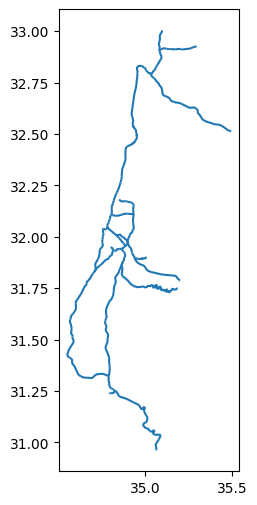

In [74]:
rail.plot();

Let us reproject `rail` back to the original CRS (i.e., ITM) before we proceed:

In [75]:
rail = rail.to_crs(epsg=2039)

```{note}
More information on specifying projections, and reprojecting layers, can be found in the [Projections](https://geopandas.org/docs/user_guide/projections.html) article.
```

(geopandas-numeric-calculations)=
## Numeric calculations

### Overview

In this section, we cover commonly-used geometric calculations that result in numeric values, using `geopandas`. As we will see, the first three operations are very similar to their `shapely` counterparts ({numref}`numeric-calculations-shapely-geopandas`). The difference is that the calculation is applied on multiple geometries, rather than just one.

```{table} Numeric geometry calculations in <code>shapely</code> and <code>geopandas</code>
:name: numeric-calculations-shapely-geopandas

| Method | `shapely` | `geopandas` |
|:---:|:---:|:---:|
| `.length` | see {ref}`shapely-length` | see {ref}`geopandas-length` |
| `.area` | see {ref}`shapely-area` | see {ref}`geopandas-area` |
| `.distance` | see {ref}`shapely-distance` | see {ref}`geopandas-distance` |
```

The fourth operation, detecting *nearest neighbors*, which we cover last (see {ref}`nearest-neighbors`), is a little more complex and not really analogous to any `shapely`-based workflow.

(geopandas-length)=
### Length (`geopandas`)

The [`.length`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.length.html) property returns a `Series` with line *lengths* per geometry in a `GeoSeries` or `GeoDataFrame`. For example, `rail.length` returns a `Series` of railway segment lengths:

In [76]:
rail.length

0      12379.715331
1       2274.111799
3       2793.337699
4       1960.170882
5       1195.701220
           ...     
210     5975.045997
211     1913.384027
214     1603.616014
215      166.180958
216     1284.983680
Length: 161, dtype: float64

Keep in mind that all numeric calculations, such as length, area (see {ref}`geopandas-area`), and distance (see {ref}`geopandas-distance`), are returned in the coordinate units, that is, in CRS units. In our case, the CRS is ITM, where the units are meters ($m$) ({numref}`crs`). The following expression transforms the values from $m$ to $km$:

In [77]:
rail.length / 1000

0      12.379715
1       2.274112
3       2.793338
4       1.960171
5       1.195701
         ...    
210     5.975046
211     1.913384
214     1.603616
215     0.166181
216     1.284984
Length: 161, dtype: float64

This `Series` can be assigned to into a new column, such as a column named `'length_km'`, as follows:

In [78]:
rail['length_km'] = rail.length / 1000
rail

SEGMENT                            geometry  length_km
0             כפר יהושע - נשר_1  LINESTRING (205530.083 741562.9...  12.379715
1            באר יעקב-ראשונים_2  LINESTRING (181507.598 650706.1...   2.274112
3         לב המפרץ מזרח - נשר_4  LINESTRING (203482.789 744181.5...   2.793338
4             קרית גת - להבים_5  LINESTRING (178574.101 609392.9...   1.960171
5            רמלה - רמלה מזרח_6  LINESTRING (189266.58 647211.50...   1.195701
..                          ...                                 ...        ...
210           ויתקין - חדרה_215  LINESTRING (190758.23 704950.04...   5.975046
211  בית יהושע - נתניה ספיר_216  LINESTRING (187526.597 687360.3...   1.913384
214       השמונה - בית המכס_220  LINESTRING (200874.999 746209.3...   1.603616
215     לב המפרץ - בית המכס_221  LINESTRING (203769.786 744358.6...   0.166181
216         224_לוד מרכז - נתבג  LINESTRING (190553.481 654170.3...   1.284984

[161 rows x 3 columns]

All geometric operations in `geopandas` assume *planar* geometry, returning the result in the CRS units. This means that layers in a geographic CRS (such as WGS84) need to be transformed to a projected CRS (see {ref}`what-is-a-crs`) before any geometric calculation. Otherwise, numeric measurements, such as length, area, and distance, are going to be returned in decimal degree units, which usually does not make sense, as the relation between degrees and geographic distance is not a fixed one.

```{admonition} Exercise 09-a
:class: important
* Reproject the `rail` layer to geographic coordinates (`4326`), then calculate railway lengths once again. You should see the (meaningless) results in decimal degrees.
```

(geopandas-area)=
### Area (`geopandas`)

The [`.area`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.area.html) property returns a `Series` with the *area* per geometry in a `GeoSeries` or `GeoDataFrame`. For example, `towns.area` returns the area sizes of each polygon in the `towns` layer, again in CRS units ($m^2$):

In [79]:
towns.area

0      2.721176e+07
1      7.708050e+04
2      1.043253e+06
3      4.769053e+04
4      2.144091e+04
           ...     
406    2.001376e+05
407    2.246316e+05
408    1.141930e+06
409    4.076764e+04
410    3.961142e+06
Length: 411, dtype: float64

If necessary, this series can be assigned to a new column. For example, the following expression divides the area values by $1000^2$, i.e., `1000**2` to convert from $m^2$ to $km^2$, then assigns the results to a new column named `'area_km2'`:

In [80]:
towns['area_km2'] = towns.area / 1000**2
towns

Muni_Heb   Machoz    Shape_Area  \
0                       שפיר     דרום  2.721176e+07   
1                     דימונה     דרום  7.708050e+04   
2                     דימונה     דרום  1.043253e+06   
3                     זבולון     חיפה  4.769053e+04   
4                      מגידו     צפון  2.144091e+04   
..                       ...      ...           ...   
406  ללא שיפוט - אזור מעיליא     צפון  2.001376e+05   
407                   זבולון     חיפה  2.246316e+05   
408                   זבולון     חיפה  1.141930e+06   
409                רמת השרון  תל אביב  4.076764e+04   
410                 צור הדסה  ירושלים  3.961142e+06   

                               geometry   area_km2  
0    POLYGON Z ((177281.694 610056.5...  27.211760  
1    POLYGON Z ((205753.745 560693.6...   0.077080  
2    POLYGON Z ((207740.171 563476.5...   1.043253  
3    POLYGON Z ((209445.229 740507.2...   0.047691  
4    POLYGON Z ((206769.626 727131.7...   0.021441  
..                                  ...        ...  
406  POLYGON Z ((225369.655 770523.6...   0.200138  
407  POLYGON Z ((207596.214 746263.0...   0.224632  
408  POLYGON Z ((208622.688 746540.1...   1.141930  
409  POLYGON Z ((183576.756 673627.0...   0.040768  
410  POLYGON Z ((209871.005 625364.9...   3.961142  

[411 rows x 5 columns]

```{admonition} Exercise 09-b
:class: important
* Find out the names of the largest and the smallest municipal area polygon, in terms of area size, based on the `towns` layer. (answer: `'ללא שיפוט - אזור נחל ארבל'` and `'רמת נגב'`)
```

```{admonition} Exercise 09-c
:class: important
* Check the association between the `'area_km2'` column we calculated, and the `'Shape_Area'` column which is stored in the Shapefile, using a scatterplot (see {ref}`scatterplots`) ({numref}`exercise-09-c`).
```

```{glue:figure} exercise-09-c
---
name: exercise-09-c
---
Solution of exercise-09-c: Association between the (calculated) `'area_km2'` column and the (original) `'Shape_Area'` column
```

(geopandas-distance)=
### Distance (`geopandas`)

The [`.distance`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.distance.html) method can be used to calculate *distances*. Each distance is calculated exactly the same way as in `shapely`, i.e., minimal distance between the geometries assuming planar coordinates. However, since we are dealing with multiple inputs, the `geopandas` mode of operation is different. Specifically, the `geopandas` operation of `.distance` (and other pairwise methods, see below) can work in two "modes":

* Many-to-One--- when the "second" argument is a `shapely` geometry ({numref}`geopandas-pairwise`, left)
* Pairwise---when the "second" argument is a `GeoSeries` ({numref}`geopandas-pairwise`, right)

```{figure} images/gpd-one_to_many_pairsise.svg
---
name: geopandas-pairwise
---
`geopandas` modes of operation for methods accepting pairs of inputs, such as `.distance`: many-to-one (left) and pairwise (right) (Source: <https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.distance.html>)
```

The following example demonstrates the many-to-one option. Here, we are calculating the distances between: 

* `stations`—all railway stations, and 
* `rail.geometry.iloc[0]`—the *first* railway segment. 

The result is a `Series` of distances, in $m$:

In [81]:
stations.distance(rail.geometry.iloc[0])

0      84284.975205
1      50424.920267
2      74235.170679
3     138847.580690
4      86603.473121
          ...      
58      8595.362486
59    160138.041969
60      9758.724335
61     84904.898970
62     26515.877484
Length: 63, dtype: float64

What if we need to calculate the complete *matrix* of pairwise distances, between each station and each railway segment? This can be done using `.apply` (see {ref}`apply-and-custom-functions`). The following [expression](https://stackoverflow.com/questions/64754025/calculate-all-distances-between-two-geodataframe-of-points-in-geopandas), in plain language, means that we take each row (`axis=1`) in `stations` as `x`, then calculate the `Series` of distances from all railway segments to the geometry of that row (`rail.distance(x.geometry)`). 


The result is a `DataFrame` representing a *distance matrix*, where:

* Rows represent railway *stations*
* Columns represent railway *segments*
* Cell values are *distances*, in meters

In [82]:
d = stations.apply(lambda x: rail.distance(x.geometry), axis=1)
d

0              1              3              4              5    \
0    84284.975205    6120.325293   91266.392666   43769.104489   13360.106887   
1    50424.920267   37379.975682   57120.870160   76795.773036   39353.653794   
2    74235.170679   13859.386195   81199.631964   53259.279461   18180.867522   
3   138847.580690   51367.336965  146064.901194   19030.199927   52794.173376   
4    86603.473121    5697.560021   94960.212976   38438.916853     289.422152   
..            ...            ...            ...            ...            ...   
58    8595.362486   86339.689331   20244.761995  123902.486603   85772.327241   
59  160138.041969   74611.504901  169029.718846   34992.788653   73042.322269   
60    9758.724335   99222.671750    6473.850217  138574.693149  100683.138956   
61   84904.898970    5579.557103   93200.557041   40156.246177    2075.672842   
62   26515.877484  120379.789258   24360.621700  159481.427917  121328.202345   

    ...            210            211            214            215  \
0   ...   46002.039665   31998.139305   94172.402848   93091.940077   
1   ...   11924.365438     236.552504   60107.821537   58958.887738   
2   ...   35958.589113   21932.455984   84145.901064   83037.130172   
3   ...  100790.724935   86796.547920  148925.381315  147885.212962   
4   ...   50857.456340   37074.116175   98521.682411   97044.665341   
..  ...            ...            ...            ...            ...   
58  ...   37220.552915   52057.048736   26186.457201   22822.683088   
59  ...  125012.376699  111083.909066  172714.053593  171172.498821   
60  ...   44196.792329   62080.870950    1709.845960    6471.883040   
61  ...   49040.957113   35245.583872   96738.721423   95275.546196   
62  ...   65575.558369   83375.846025   22375.584322   24118.556926   

              216  
0    13376.996382  
1    33548.162167  
2    14356.406044  
3    58403.590869  
4     4964.211497  
..            ...  
58   79583.761529  
59   78870.029306  
60   94617.022408  
61    3553.733949  
62  115179.615344  

[63 rows x 161 columns]

Note that the first column in the above result is identical to the `Series` we got in the previous expression.

The distance matrix can be refined to calculate more specific properties related to distance that we are interested in. For example, to get the *minimum* distance to *any* of the railway segments (rather than all distances), we can apply the `.min()` method on each row, as follows. The result is a `Series` of minimal distances per station:

In [83]:
nearest_seg_dist = d.min(axis=1)
nearest_seg_dist

0      13.440327
1       4.932094
2      16.180832
3      64.381044
4       2.941401
         ...    
58     56.102377
59      7.540327
60     44.130049
61     22.556829
62    115.502833
Length: 63, dtype: float64

We can assign it to a new column named `'nearest_seg_dist'` ("distance to nearest segment") in `stations`, as follows:

In [84]:
stations['nearest_seg_dist'] = nearest_seg_dist
stations

STAT_NAMEH  OFF_7_DAY                       geometry  \
0   ראשון לציון משה דיין       72.0  POINT (177206.094 655059.936)   
1        קרית ספיר נתניה      119.0  POINT (187592.123 687587.598)   
2              ת"א השלום     1642.0    POINT (180621.94 664537.21)   
3                  שדרות       26.0  POINT (160722.849 602798.889)   
4                   רמלה       47.0    POINT (188508.91 648466.87)   
..                   ...        ...                            ...   
58    מגדל העמק כפר ברוך        5.0  POINT (219851.931 728164.825)   
59    באר שבע אוניברסיטה      130.0  POINT (181813.614 574550.411)   
60          חיפה בת גלים      311.0    POINT (198610.01 748443.79)   
61                   לוד      238.0  POINT (188315.977 650289.373)   
62                 נהריה       64.0    POINT (209570.59 767769.22)   

    nearest_seg_dist  
0          13.440327  
1           4.932094  
2          16.180832  
3          64.381044  
4           2.941401  
..               ...  
58         56.102377  
59          7.540327  
60         44.130049  
61         22.556829  
62        115.502833  

[63 rows x 4 columns]

(nearest-neighbors)=
### Nearest neighbors

Here is another technique to extract information from the distance matrix, expanding the above expression of distance to nearest neighbor. This time, we calculate the name (`'SEGMENT'` column) of the nearest railway segment for each station. We are using the `.idxmin` method (see {numref}`pandas-aggregation-methods`), instead of `.min`, to get the *index* of the nearest segment (instead of the distance to it):

In [85]:
ids = d.idxmin(axis=1)
ids

0      22
1     100
2      57
3     131
4      87
     ... 
58    152
59    205
60    153
61     77
62     12
Length: 63, dtype: int64

The index can be used to subset segment names (`rail['SEGMENT']`). The result is a series of the nearest segment names:

In [86]:
nearest_seg_name = rail['SEGMENT'].loc[ids]
nearest_seg_name

22              משה דיין-קוממיות_23
100    נתניה מכללה - נתניה ספיר_101
57           סבידור מרכז - השלום_58
131              שדרות-יד מרדכי_134
87                    לוד - רמלה_88
                   ...             
152            עפולה - כפר ברוך_155
205    באר שבע צפון - באר שבע אוניב
153          חוף כרמל - בת גלים_156
77                    לוד - רמלה_78
12                   נהריה - עכו_13
Name: SEGMENT, Length: 63, dtype: object

Let's attach the result to another column in the `stations` table, named `nearest_seg_name` ("nearest segment name"). We need to reset the indices to make sure the column is attached by position:

In [87]:
nearest_seg_name = nearest_seg_name.reset_index(drop=True)
nearest_seg_name

0              משה דיין-קוממיות_23
1     נתניה מכללה - נתניה ספיר_101
2           סבידור מרכז - השלום_58
3               שדרות-יד מרדכי_134
4                    לוד - רמלה_88
                  ...             
58            עפולה - כפר ברוך_155
59    באר שבע צפון - באר שבע אוניב
60          חוף כרמל - בת גלים_156
61                   לוד - רמלה_78
62                  נהריה - עכו_13
Name: SEGMENT, Length: 63, dtype: object

In [88]:
stations['nearest_seg_name'] = nearest_seg_name
stations

STAT_NAMEH  OFF_7_DAY                       geometry  \
0   ראשון לציון משה דיין       72.0  POINT (177206.094 655059.936)   
1        קרית ספיר נתניה      119.0  POINT (187592.123 687587.598)   
2              ת"א השלום     1642.0    POINT (180621.94 664537.21)   
3                  שדרות       26.0  POINT (160722.849 602798.889)   
4                   רמלה       47.0    POINT (188508.91 648466.87)   
..                   ...        ...                            ...   
58    מגדל העמק כפר ברוך        5.0  POINT (219851.931 728164.825)   
59    באר שבע אוניברסיטה      130.0  POINT (181813.614 574550.411)   
60          חיפה בת גלים      311.0    POINT (198610.01 748443.79)   
61                   לוד      238.0  POINT (188315.977 650289.373)   
62                 נהריה       64.0    POINT (209570.59 767769.22)   

    nearest_seg_dist              nearest_seg_name  
0          13.440327           משה דיין-קוממיות_23  
1           4.932094  נתניה מכללה - נתניה ספיר_101  
2          16.180832        סבידור מרכז - השלום_58  
3          64.381044            שדרות-יד מרדכי_134  
4           2.941401                 לוד - רמלה_88  
..               ...                           ...  
58         56.102377          עפולה - כפר ברוך_155  
59          7.540327  באר שבע צפון - באר שבע אוניב  
60         44.130049        חוף כרמל - בת גלים_156  
61         22.556829                 לוד - רמלה_78  
62        115.502833                נהריה - עכו_13  

[63 rows x 5 columns]

The last example can be considered as a "manually" constructed nearest-neighbor spatial join, since we actually joined an attribute (`'SEGMENT'`) value from one layer (`rail`) to another layer (`stations`), based on minimum distance. Towards the end of this chapter we will introduce the the `gpd.sjoin_nearest` function which can do nearest-neighbor spatial join automatically (see {ref}`nearest-neighbor-join`).

(geopandas-new-geometries-1)=
## New geometries 1 (`geopandas`)

### Overview

In this section and the next one, we learn about functions that calculate new geometries. We are already familiar with this type of operations for individual geometry objects, using `shapely` (see {ref}`shapely-new-geometries-1` and {ref}`shapely-new-geometries-2`). Now, we learn about the same type of operations for vector layers, which include more than one geometry. Similarly to our treatment of `shapely` methods, we split the discussion into two parts: operations on single geometries (this section), and operations on pairs of geometries ({ref}`geopandas-new-geometries-2`).

The single-geometry methods are similar to the `shapely` methods ({numref}`geopandas-new-geoms-individual`), only that they accept a `GeoSeries` (or `GeoDataFrame`) and return a new `GeoSeries` with the results. In fact, the `geopandas` methods are simply "wrappers" of the respective `shapely` methods. We will demonstrate just the two most commonly used methods, `.centroid` ({ref}`geopandas-centroids`) and `.buffer` ({ref}`geopandas-buffers`). For example, when applying `.centroid` on a vector layer or geometry column, we get a new geometry column, with the same number of geometries as the original, where each geometry is the centroid of the respective original geometry. 

```{table} <code>geopandas</code> properties and methods which create a new geometry from an input <code>GeoSeries</code> or <code>GeoDataFrame</code>
:name: geopandas-new-geoms-individual

| Property or Method | Meaning |
|:---:|:---:|
| [`.centroid`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.centroid.html) | {ref}`geopandas-centroids` |
| [`.buffer()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html) | {ref}`geopandas-buffers` |
| [`.convex_hull`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.convex_hull.html) | Convex Hull |
| [`.envelope`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.envelope.html) | Envelope |
| [`.minimum_rotated_rectangle`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.minimum_rotated_rectangle.html) | Minimum rotated rectangle | 
| [`.simplify()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.simplify.html) | Simplified geometry | 
```

(geopandas-centroids)=
### Centroids (`geopandas`)

The [`.centroid`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.centroid.html) method, applied on a `GeoSeries` or `GeoDataFrame`, returns a new `GeoSeries` with the centroids. For example, here is how we can create a `GeoSeries` of town polygon centroids:

In [89]:
ctr = towns.centroid
ctr

0      POINT (177487.729 608814.771)
1      POINT (205649.879 560604.535)
2      POINT (207998.865 562886.601)
3      POINT (209338.568 740382.523)
4      POINT (206932.541 727058.938)
                   ...              
406    POINT (225182.898 770809.745)
407     POINT (208021.906 746132.09)
408     POINT (208513.59 747266.263)
409    POINT (183415.358 673541.053)
410    POINT (209371.055 625163.901)
Length: 411, dtype: geometry

And here is a plot of the result:

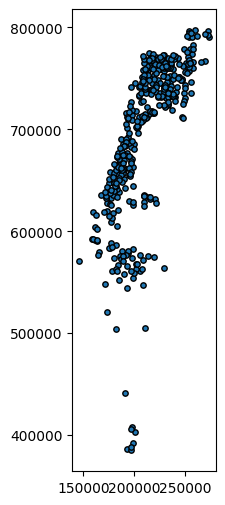

In [90]:
ctr.plot(markersize=15, edgecolor='black');

(geopandas-buffers)=
### Buffers (`geopandas`)

The [`.buffer`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html) method buffers each geometry in a given `GeoDataFrame` or `GeoSeries` to the specified distance. It returns a `GeoSeries` with the resulting polygons. For example, here we create buffers of 5,000 $m$ (i.e., 5 $km$) around each railway station:

In [91]:
stations_buffer = stations.buffer(5000)
stations_buffer

0     POLYGON ((182206.094 655059.936...
1     POLYGON ((192592.123 687587.598...
2     POLYGON ((185621.94 664537.21, ...
3     POLYGON ((165722.849 602798.889...
4     POLYGON ((193508.91 648466.87, ...
                     ...                
58    POLYGON ((224851.931 728164.825...
59    POLYGON ((186813.614 574550.411...
60    POLYGON ((203610.01 748443.79, ...
61    POLYGON ((193315.977 650289.373...
62    POLYGON ((214570.59 767769.22, ...
Length: 63, dtype: geometry

Here is a plot of the result:

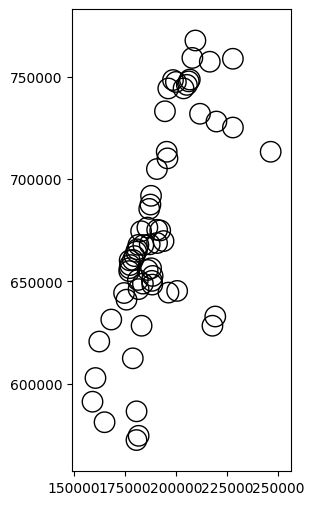

In [92]:
stations_buffer.plot(color='none');

```{admonition} Exercise 09-d
:class: important
* As shown above, centroids and buffers are returned as a `GeoSeries`
* Suppose that, instead, you need a `GeoDataFrame` with the original attributes of the source layer (e.g., the railway station properties) *and* the centroid, or buffer, geometries. How can we create such `GeoDataFrame`s?
```

(geopandas-new-geometries-2)=
## New geometries 2 (`geopandas`)

(geopandas-new-geometries-2-pairwise)=
### Pairwise methods

`geopandas` defines analogous pairwise methods ({numref}`geopandas-new-geoms-pair`), with the same functionality as those we are familiar from `shapely` ({numref}`shapely-new-geoms-pair`).

```{table} <code>geopandas</code> pairwise methods which create a new <code>GeoSeries</code>, given a <code>GeoSeries</code> and a <code>shapely</code> geometry (many-to-one) or two <code>GeoSeries</code> (pairwise) 
:name: geopandas-new-geoms-pair

| Method | Meaning |
|:---:|:---:|
| [`.intersection`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.intersection.html) | Intersection |
| [`.union`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.union.html) | Union |
| [`.difference`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.difference.html) | Difference |
| [`.symmetric_difference`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.symmetric_difference.html#geopandas.GeoSeries.symmetric_difference) | Symmetric difference |
```

The methods listed in {numref}`geopandas-new-geoms-pair` can also be used in the two modes mentioned for `.distance` ({ref}`geopandas-distance`), namely many-to-one or pairwise ({numref}`geopandas-pairwise`). In the following example we demonstrate the first mode (many-to-one), which is both simpler and more useful. For the first ("many") input we'll take `towns`, while for the second ("one") geometry, we'll take a particular railway segment, part of the line that goes from Tel-Aviv to Jerusalem:

In [93]:
seg = rail[rail['SEGMENT'] == 'נתבג - יצחק נבון_198']
seg

SEGMENT                            geometry  length_km
194  נתבג - יצחק נבון_198  LINESTRING (194999.696 643851.4...  27.985833

Given `towns` and `seg`, we will calculate pairwise intersections, that is, the segment portions that go through each town.

An interactive map of the inputs, `seg` and the `towns` features it intersects with, is shown below. Note that we are using `.intersects` to subset the towns layer, which will be explained later ({ref}`geopandas-geometric-relations`). Also note the technique being used to show two different layers in the same `.explore` plot (similar to what we learned about `.plot`, see {ref}`geopandas-plotting-more-than-one-layer`).

In [94]:
m = towns[towns.intersects(seg.union_all())].explore()
seg.explore(m = m, color='red', style_kwds={'weight':8, 'opacity':0.8})

Here is how we can use the `.intersection` method to find the intersections of all `town` polygons (many) with the railway segment `seg` (one). We'll call the result `seg1`:

In [95]:
seg1 = towns.intersection(seg.geometry.iloc[0])
seg1

0      LINESTRING Z EMPTY
1      LINESTRING Z EMPTY
2      LINESTRING Z EMPTY
3      LINESTRING Z EMPTY
4      LINESTRING Z EMPTY
              ...        
406    LINESTRING Z EMPTY
407    LINESTRING Z EMPTY
408    LINESTRING Z EMPTY
409    LINESTRING Z EMPTY
410    LINESTRING Z EMPTY
Length: 411, dtype: geometry

`seg1` is a `GeoSeries` of the same lenght of `towns`, with the intersections between each town and the segment `seg`. Naturally, most of the resulting geometries are empty, since there are no intersections between most towns and the one particular railway segment. We can filter out empty geometries using the [`.is_empty`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.is_empty.html) property:

In [96]:
seg1 = seg1[~seg1.is_empty]
seg1

161    LINESTRING Z (194999.696 643851...
268    LINESTRING Z (195949.355 642639...
300    LINESTRING Z (217013.82 635020....
328    LINESTRING Z (202640.669 637654...
dtype: geometry

Also, let's switch to a `GeoDataFrame` representation:

In [97]:
seg1 = gpd.GeoDataFrame(geometry=seg1)
seg1

geometry
161  LINESTRING Z (194999.696 643851...
268  LINESTRING Z (195949.355 642639...
300  LINESTRING Z (217013.82 635020....
328  LINESTRING Z (202640.669 637654...

Here is the result:

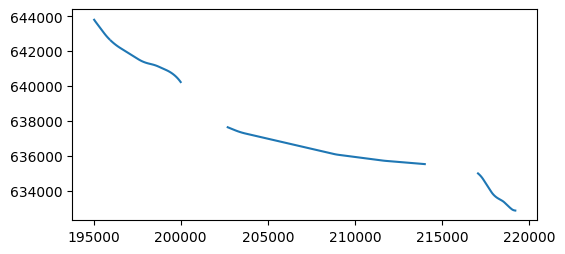

In [98]:
seg1.plot();

Typically we want to know the details of each segment, such as the attributes of the town it goes through. Using `pd.concat` (see {ref}`pandas-concatenation`), we can combine `seg1` with matching attributes from `towns` (aligned by index):


In [99]:
seg1 = pd.concat([seg1, towns[['Muni_Heb']]], axis=1, join='inner')
seg1

geometry                Muni_Heb
161  LINESTRING Z (194999.696 643851...  מודיעין - מכבים - רעות
268  LINESTRING Z (195949.355 642639...                     גזר
300  LINESTRING Z (217013.82 635020....                 ירושלים
328  LINESTRING Z (202640.669 637654...               מטה יהודה

Now we have the geometry of each `seg` part which goes through every particular town, as well as the properties of that town.

```{note}
Alternatively, we could use the [`.join`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html#pandas.DataFrame.join) method (of `pandas`) to combine two tables by index, which has shorter and cleaner syntax for this case:

```py
seg1.join(towns[['Muni_Heb']])
```

To plot the result with a legend, we have to resort to a trick to reverse the town name strings. Otherwise, the Hebrew text is shown in reverse order:

In [100]:
towns1 = towns[towns.intersects(seg1.union_all())]
towns1.loc[:, 'Muni_Heb'] = towns1['Muni_Heb'].apply(lambda x: x[::-1])
seg1.loc[:, 'Muni_Heb'] = seg1['Muni_Heb'].apply(lambda x: x[::-1])

Here is a plot of:

* The town polygons `towns` (in color, according to `Muni_Heb`)
* The railway segment `seg` (in black)
* The intersection result `seg1` (in color, according to `Muni_Heb`)

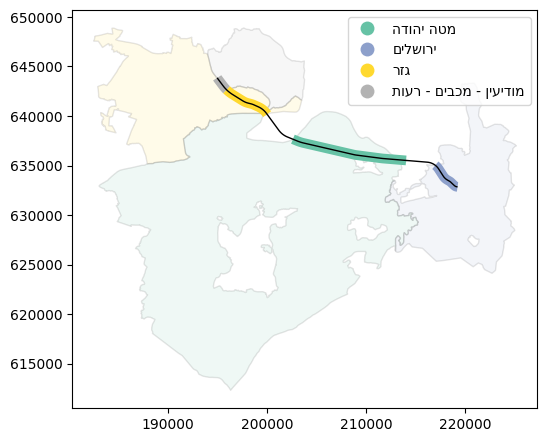

In [101]:
base = towns1.plot(column='Muni_Heb', cmap='Set2', edgecolor='black', alpha=0.1)
seg1.plot(ax=base, column='Muni_Heb', cmap='Set2', linewidth=7, legend=True)
seg.plot(ax=base, color='black', linewidth=1);

(geopandas-set-operations)=
### Set-operations (`.overlay`)

In addition to the standard methods, such as `.intersection` ({ref}`geopandas-new-geometries-2-pairwise`), `geopandas` defines the [`.overlay`](https://geopandas.org/en/stable/docs/reference/api/geopandas.overlay.html) method. Using `.overlay`, we can "split" one layer with another, while keeping the original attributes of both inputs, for each part. The `how` argument determines which of the parts are returned. For example:

* `how='intersection'`---returns only the shared parts
* `how='union'`---returns all parts

The complete list of `.overlay(how=...)` options is given in {numref}`geopandas-overlay`.

```{table} New geometry calculations using <code>.overlay</code>
:name: geopandas-overlay

| Method | Meaning |
|---|---|
| `.overlay(how='intersection')` | Shared parts only |
| `.overlay(how='union')` | All parts |
| `.overlay(how='difference')` | Parts of the first geometry only (without shared) |
| `.overlay(how='symmetric_difference')` | Parts of the first or second geometry (without shared) |
| `.overlay(how='identity')` | Parts of the first geometry or shared |
```

This will be made clear in the following example. The following `.overlay` expression calculates the pairwise intersections between railway segments (`rail`) and towns (`towns`), creating a new layer of pairwise intersections `rail_towns`:

In [102]:
rail_towns = rail.overlay(towns[['Muni_Heb', 'geometry']])
rail_towns

SEGMENT  length_km                   Muni_Heb  \
0             כפר יהושע - נשר_1  12.379715  ללא שיפוט - אזור הר הכרמל   
1             כפר יהושע - נשר_1  12.379715                        נשר   
2             כפר יהושע - נשר_1  12.379715                 קרית טבעון   
3             כפר יהושע - נשר_1  12.379715                     זבולון   
4             כפר יהושע - נשר_1  12.379715                 עמק יזרעאל   
..                          ...        ...                        ...   
278  בית יהושע - נתניה ספיר_216   1.913384                      נתניה   
279  בית יהושע - נתניה ספיר_216   1.913384                  חוף השרון   
280       השמונה - בית המכס_220   1.603616                       חיפה   
281     לב המפרץ - בית המכס_221   0.166181                       חיפה   
282         224_לוד מרכז - נתבג   1.284984                    שדות דן   

                               geometry  
0    LINESTRING Z (209316.903 736321...  
1    LINESTRING Z (205530.083 741562...  
2    LINESTRING Z (210111.094 732877...  
3    LINESTRING Z (206157.238 740691...  
4    LINESTRING Z (210658.396 732427...  
..                                  ...  
278  LINESTRING Z (187526.597 687360...  
279  LINESTRING Z (187356.05 686718....  
280  LINESTRING Z (200874.999 746209...  
281  LINESTRING Z (203769.786 744358...  
282  LINESTRING Z (190553.481 654170...  

[283 rows x 4 columns]

To understand what has happened, consider the specific segment in the `rail` layer from the last example ({ref}`geopandas-new-geometries-2-pairwise`):

In [103]:
rail[rail['SEGMENT'] == 'נתבג - יצחק נבון_198']

SEGMENT                            geometry  length_km
194  נתבג - יצחק נבון_198  LINESTRING (194999.696 643851.4...  27.985833

In the result of the overlay operation `rail_towns`, this particular segment was split into four parts, as it crosses four different polygons from the `towns` layer. We can see, in the result, the names of those `towns` features:

In [104]:
seg = rail_towns[rail_towns['SEGMENT'] == 'נתבג - יצחק נבון_198']
seg

SEGMENT  length_km                Muni_Heb  \
257  נתבג - יצחק נבון_198  27.985833  מודיעין - מכבים - רעות   
258  נתבג - יצחק נבון_198  27.985833                     גזר   
259  נתבג - יצחק נבון_198  27.985833                 ירושלים   
260  נתבג - יצחק נבון_198  27.985833               מטה יהודה   

                               geometry  
257  LINESTRING Z (194999.696 643851...  
258  LINESTRING Z (195949.355 642639...  
259  LINESTRING Z (217013.82 635020....  
260  LINESTRING Z (202640.669 637654...

as demonstrated in the following plot:

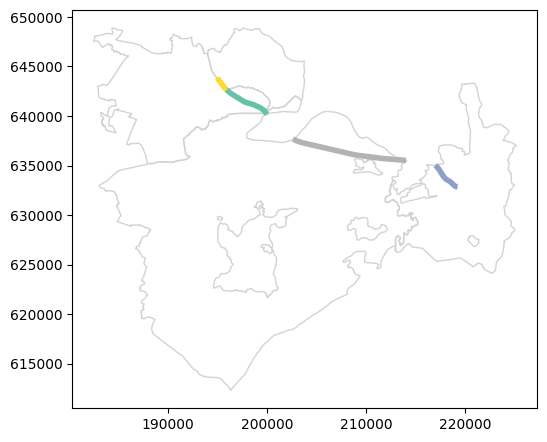

In [105]:
base = towns[towns.intersects(seg.union_all())].plot(color='none', edgecolor='lightgrey')
seg.plot(ax=base, column='Muni_Heb', cmap='Set2', linewidth=4, missing_kwds={'color':'black', 'linewidth':1});

Thus, `.overlay` with `how='intersection'` can be thought of as an expanded version of `.intersection` ({ref}`geopandas-new-geometries-2-pairwise`), where we calculate intersection in a "many-to-many" mode (between all towns and all railway segments), and also get the respective attributes without having to manually join them.

You may notice that only overlapping parts of the two layers were returned, as a result of (the default) `how='intersection'` setting of `.overlay`. To get *all* parts, we could use `how='union'`:

In [106]:
rail_towns = rail.overlay(towns[['Muni_Heb', 'geometry']], how='union')
rail_towns

/home/michael/Sync/venv/m/lib/python3.12/site-packages/geopandas/geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 411 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


SEGMENT  length_km                   Muni_Heb  \
0              כפר יהושע - נשר_1  12.379715  ללא שיפוט - אזור הר הכרמל   
1              כפר יהושע - נשר_1  12.379715                        נשר   
2              כפר יהושע - נשר_1  12.379715                 קרית טבעון   
3              כפר יהושע - נשר_1  12.379715                     זבולון   
4              כפר יהושע - נשר_1  12.379715                 עמק יזרעאל   
..                           ...        ...                        ...   
302      בני ברק - קרית אריה_191   3.135967                        NaN   
303         נתבג - יצחק נבון_198  27.985833                        NaN   
304  קרית מוצקין - סביוני ים_212   3.555612                        NaN   
305   בית יהושע - נתניה ספיר_216   1.913384                        NaN   
306                          NaN        NaN                       מגדל   

                               geometry  
0    LINESTRING Z (209316.903 736321...  
1    LINESTRING Z (205530.083 741562...  
2    LINESTRING Z (210111.094 732877...  
3    LINESTRING Z (206157.238 740691...  
4    LINESTRING Z (210658.396 732427...  
..                                  ...  
302  LINESTRING Z (185847.279 667798...  
303  MULTILINESTRING Z ((200031.323 ...  
304  LINESTRING Z (207382.568 749536...  
305  LINESTRING Z (187356.05 686718....  
306  LINESTRING Z (246764.475 748264...  

[307 rows x 4 columns]

```{note}
The above `.overlay(..., how='union')` expression returns all parts of both input layers but only if they are of the same type (lines!) as the first input layer `rail`. This is the default `keep_geom_type=True` behavior. In this case, it's exactly what we want; otherwise we would get all parts of the town polygons as well.
```

Now, our particular `rail` segment (as well as any other segment) was split to parts per town, but also has a separate part for the those sections that do not overlap with any `towns`, if any (with `Muni_Heb` set to `np.nan`):

In [107]:
seg = rail_towns[rail_towns['SEGMENT'] == 'נתבג - יצחק נבון_198']
seg

SEGMENT  length_km                Muni_Heb  \
257  נתבג - יצחק נבון_198  27.985833  מודיעין - מכבים - רעות   
258  נתבג - יצחק נבון_198  27.985833                     גזר   
259  נתבג - יצחק נבון_198  27.985833                 ירושלים   
260  נתבג - יצחק נבון_198  27.985833               מטה יהודה   
303  נתבג - יצחק נבון_198  27.985833                     NaN   

                               geometry  
257  LINESTRING Z (194999.696 643851...  
258  LINESTRING Z (195949.355 642639...  
259  LINESTRING Z (217013.82 635020....  
260  LINESTRING Z (202640.669 637654...  
303  MULTILINESTRING Z ((200031.323 ...

The plot demonstrates the new result (we use `missing_kwds` to make sure features with "No Data" for `Muni_Heb` are also plotted):

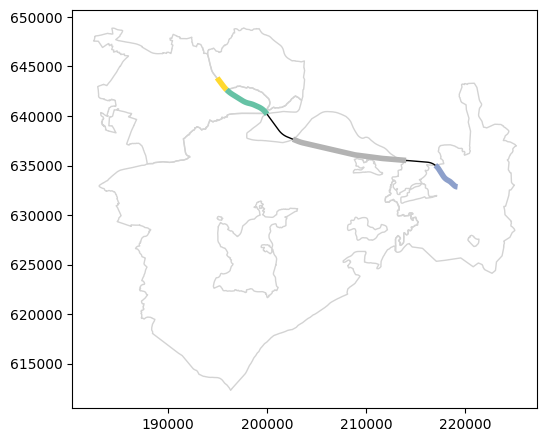

In [108]:
base = towns[towns.intersects(seg.union_all())].plot(color='none', edgecolor='lightgrey')
seg.plot(ax=base, column='Muni_Heb', cmap='Set2', linewidth=4, missing_kwds={'color':'black', 'linewidth':1});

Note that the `length_km` attribute was "inherited" from the original `rail` layer, and it no longer represents the length of the sub-segments resulting from the overlay operation:

In [109]:
seg

SEGMENT  length_km                Muni_Heb  \
257  נתבג - יצחק נבון_198  27.985833  מודיעין - מכבים - רעות   
258  נתבג - יצחק נבון_198  27.985833                     גזר   
259  נתבג - יצחק נבון_198  27.985833                 ירושלים   
260  נתבג - יצחק נבון_198  27.985833               מטה יהודה   
303  נתבג - יצחק נבון_198  27.985833                     NaN   

                               geometry  
257  LINESTRING Z (194999.696 643851...  
258  LINESTRING Z (195949.355 642639...  
259  LINESTRING Z (217013.82 635020....  
260  LINESTRING Z (202640.669 637654...  
303  MULTILINESTRING Z ((200031.323 ...

If necessary, we can "update" the length attribute by recalculating geometry lengths:

In [110]:
rail_towns['length_km'] = rail_towns.length / 1000
seg = rail_towns[rail_towns['SEGMENT'] == 'נתבג - יצחק נבון_198']
seg

SEGMENT  length_km                Muni_Heb  \
257  נתבג - יצחק נבון_198   1.541502  מודיעין - מכבים - רעות   
258  נתבג - יצחק נבון_198   4.835012                     גזר   
259  נתבג - יצחק נבון_198   3.198949                 ירושלים   
260  נתבג - יצחק נבון_198  11.660362               מטה יהודה   
303  נתבג - יצחק נבון_198   6.750008                     NaN   

                               geometry  
257  LINESTRING Z (194999.696 643851...  
258  LINESTRING Z (195949.355 642639...  
259  LINESTRING Z (217013.82 635020....  
260  LINESTRING Z (202640.669 637654...  
303  MULTILINESTRING Z ((200031.323 ...

The sum of the sub-segment lenghts is (approximately) equal to the length of the complete original segment, as can be expected:

In [111]:
x = seg['length_km'].sum()
y = rail[rail['SEGMENT'] == 'נתבג - יצחק נבון_198']['length_km'].iloc[0]
round(x, 6) == round(y, 6)

np.True_

```{note}
For more information on set operations in `geopandas`, see the [Set operations with overlay](https://geopandas.org/en/stable/docs/user_guide/set_operations.html) article.
```

(geopandas-unary-union)=
### Unary union (`.union_all`)

It is also worth mentioning the [`.union_all`](https://geopandas.org/en/latest/docs/reference/api/geopandas.GeoSeries.union_all.html) method, which returns the union of all geometries in a `GeoSeries` or `GeoDataFrame`. It can be thought of as sucessive pairwise union of all geometries in a layer, but more efficient and using short syntax. The output of `.union_all` is a `shapely` geometry, as union of all geometries into one "loses" the attribute data, if any.

For example, `rail.union_all()` returns a `'MultiLineString'` geometry of all railway lines combined into one multi-part geometry:

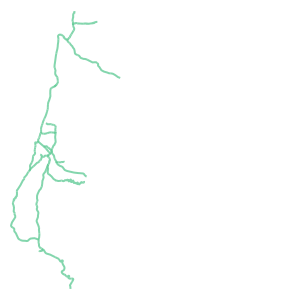

In [112]:
rail.union_all()

`.union_all` can be useful when we need to treat all geometries as a single unit. For example, suppose we want to calculate the area that is within 1.5 $km$ of any railway line:

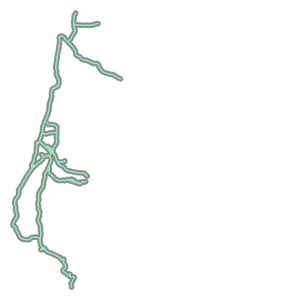

In [113]:
rail.union_all().buffer(1500)

In [114]:
rail.union_all().buffer(1500).area / 1000**2  ## Area in km^2

1840.1464164412746

(geopandas-dissolve)=
## Aggregation (`.dissolve`)

### What is dissolving?

Aggregating a vector layer is similar to aggregating a table (see {ref}`pandas-aggregation`), in the sense that particular functions are applied on groups of rows, to summarize column values per group. The difference is that, when aggregating a vector layer, the geometries are aggregated as well, through *dissolving*, as in `.union_all` (see {ref}`geopandas-unary-union`). 

For example, the `towns` layer has duplicate polygons per town, in cases when a particular town is discontinous, i.e., composed of more than one "part". We can find that out using the `.value_counts` method (see {ref}`pandas-value-counts`), which returns the number of occurences of each value in a `Series`:

In [115]:
towns['Muni_Heb'].value_counts()

Muni_Heb
מבואות החרמון    12
מעלה יוסף         6
הגליל העליון      6
מרום הגליל        5
משגב              5
                 ..
בת ים             1
אזור              1
אבו גוש           1
צור הדסה          1
אליכין            1
Name: count, Length: 285, dtype: int64

We can immediately see that the count `Series` contains values greater than `1` (up to `12`), which means that there are towns represented by more than one row. For example, the regional council called `'מבואות החרמון'` is composed of 12 separate parts:

In [116]:
towns[towns['Muni_Heb'] == 'מבואות החרמון'].explore()

We can also see that all geometries are of type `'Polygon'`:

In [117]:
towns.geom_type.value_counts()

Polygon    411
Name: count, dtype: int64

Aggregation of a `'Polygon'` layer may create `'MultiPolygon'` geometries. For example, as a result of dissolving the `towns` layer by town name, the 12 rows with `'Polygon'` geometries of `'מבואות החרמון'` are going to turn into one row, with a `'MultiPolygon'` geometry (see below, {ref}`dissolving-by-town-name`). 

(dissolving-by-town-name)=
### Dissolving by town name

Usually we want to have each towns' information in a single row, to treat it as one unit. For instance, we usually are interested in the total `.area` of all parts of each town, at once, even if they are discontinuous in space. Therefore, we prefer to work with an aggregated the `towns` layer, grouping by town names (`'Muni_Heb'`). 

With `geopandas`, a vector layer can be aggregated using the [`.dissolve`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.dissolve.html) method, specifying: 

* `by`—The name of the column used for to grouping
* `aggfunc`—The function used to summarize the non-spatial columns:
    * `'first'` (the default)
    * `'last'`
    * `'min'`
    * `'max'`
    * `'sum'`
    * `'mean'`
    * `'median'`

For example, the following expression aggregates the `towns` layer by town name (`'Muni_Heb'`), taking the first value of all other attributes per town:

In [118]:
towns = towns.dissolve(by='Muni_Heb')
towns

geometry   Machoz    Shape_Area  \
Muni_Heb                                                                   
אבו גוש        POLYGON Z ((209066.649 635655.2...  ירושלים  1.891242e+06   
אבו סנאן       POLYGON Z ((217410.883 764485 0...     צפון  6.455340e+06   
אבן יהודה      POLYGON Z ((189840.556 684299.2...     מרכז  8.141995e+06   
אום אל פחם     MULTIPOLYGON Z (((211644.29 712...     חיפה  2.572947e+07   
אופקים         POLYGON Z ((164806.146 577898.8...     דרום  1.635240e+07   
...                                           ...      ...           ...   
שפרעם          POLYGON Z ((215213.126 744570.3...     צפון  1.962961e+07   
תל אביב - יפו  POLYGON Z ((186077.611 668970.3...  תל אביב  5.709665e+07   
תל מונד        POLYGON Z ((191635.04 682046.98...     מרכז  7.127011e+06   
תל שבע         POLYGON Z ((186092.189 571779.8...     דרום  9.421072e+06   
תמר            MULTIPOLYGON Z (((218488.641 57...     דרום  2.560956e+07   

                area_km2  
Muni_Heb                  
אבו גוש         1.891242  
אבו סנאן        6.455340  
אבן יהודה       8.141995  
אום אל פחם     25.729469  
אופקים         16.352399  
...                  ...  
שפרעם          19.629615  
תל אביב - יפו  57.096655  
תל מונד         7.127011  
תל שבע          9.421072  
תמר            25.609563  

[285 rows x 4 columns]

Just like in ordinary aggregation, the column which is used for grouping is automatically transferred to the *index* of the resulting `GeoDataFrame`. To place it back to an ordinary column, we can use `.reset_index` (see {ref}`resetting-the-index`):

In [119]:
towns = towns.reset_index()
towns

Muni_Heb                            geometry   Machoz    Shape_Area  \
0          אבו גוש  POLYGON Z ((209066.649 635655.2...  ירושלים  1.891242e+06   
1         אבו סנאן  POLYGON Z ((217410.883 764485 0...     צפון  6.455340e+06   
2        אבן יהודה  POLYGON Z ((189840.556 684299.2...     מרכז  8.141995e+06   
3       אום אל פחם  MULTIPOLYGON Z (((211644.29 712...     חיפה  2.572947e+07   
4           אופקים  POLYGON Z ((164806.146 577898.8...     דרום  1.635240e+07   
..             ...                                 ...      ...           ...   
280          שפרעם  POLYGON Z ((215213.126 744570.3...     צפון  1.962961e+07   
281  תל אביב - יפו  POLYGON Z ((186077.611 668970.3...  תל אביב  5.709665e+07   
282        תל מונד  POLYGON Z ((191635.04 682046.98...     מרכז  7.127011e+06   
283         תל שבע  POLYGON Z ((186092.189 571779.8...     דרום  9.421072e+06   
284            תמר  MULTIPOLYGON Z (((218488.641 57...     דרום  2.560956e+07   

      area_km2  
0     1.891242  
1     6.455340  
2     8.141995  
3    25.729469  
4    16.352399  
..         ...  
280  19.629615  
281  57.096655  
282   7.127011  
283   9.421072  
284  25.609563  

[285 rows x 5 columns]

Note that we now have the same number of rows as the number of unique town names. Also, the geometry types are now either `'Polygon'` or `'MultiPolygon'` (why?):

In [120]:
towns.geom_type.value_counts()

Polygon         221
MultiPolygon     64
Name: count, dtype: int64

For example, here is the single entry for `'מבואות החרמון'`, which is now a `'MultiPolygon'`:

In [121]:
towns[towns['Muni_Heb'] == 'מבואות החרמון']

Muni_Heb                            geometry Machoz    Shape_Area  \
176  מבואות החרמון  MULTIPOLYGON Z (((252449.171 75...   צפון  2.424360e+06   

     area_km2  
176   2.42436

Finally, the `'Shape_Area'` and `'area_km2'` columns are not necessarily correct anymore (why?). We can drop or re-calculate them:

In [122]:
towns = towns.drop('Shape_Area', axis=1)
towns['area_km2'] = towns.area / 1000**2
towns

Muni_Heb                            geometry   Machoz     area_km2
0          אבו גוש  POLYGON Z ((209066.649 635655.2...  ירושלים     1.891242
1         אבו סנאן  POLYGON Z ((217410.883 764485 0...     צפון     6.455340
2        אבן יהודה  POLYGON Z ((189840.556 684299.2...     מרכז     8.141995
3       אום אל פחם  MULTIPOLYGON Z (((211644.29 712...     חיפה    26.028294
4           אופקים  POLYGON Z ((164806.146 577898.8...     דרום    16.352399
..             ...                                 ...      ...          ...
280          שפרעם  POLYGON Z ((215213.126 744570.3...     צפון    19.629615
281  תל אביב - יפו  POLYGON Z ((186077.611 668970.3...  תל אביב    57.096655
282        תל מונד  POLYGON Z ((191635.04 682046.98...     מרכז     7.127011
283         תל שבע  POLYGON Z ((186092.189 571779.8...     דרום     9.421072
284            תמר  MULTIPOLYGON Z (((218488.641 57...     דרום  1500.041968

[285 rows x 4 columns]

Here is the revised entry for `'מבואות החרמון'`:

In [123]:
towns[towns['Muni_Heb'] == 'מבואות החרמון']

Muni_Heb                            geometry Machoz    area_km2
176  מבואות החרמון  MULTIPOLYGON Z (((252449.171 75...   צפון  134.816362

(dissolving-by-district)=
### Dissolving by district

As another example of dissolving, let us now use `'Machoz'` (district) as the grouping column. This refers to a higher-level administrative division, and there are just six districts in Israel. The dissoved layer is thus composed of six features:

In [124]:
districts = towns.dissolve(by='Machoz').reset_index()
districts

Machoz                            geometry    Muni_Heb   area_km2
0     דרום  POLYGON Z ((214342.276 467536.8...      אופקים  16.352399
1     חיפה  MULTIPOLYGON Z (((205341.469 70...  אום אל פחם  26.028294
2  ירושלים  POLYGON Z ((210711.062 624658.6...     אבו גוש   1.891242
3     מרכז  POLYGON Z ((176923.016 632550.2...   אבן יהודה   8.141995
4     צפון  MULTIPOLYGON Z (((222775.875 71...    אבו סנאן   6.455340
5  תל אביב  MULTIPOLYGON Z (((177311.878 65...   אור יהודה   7.613271

Here is a visualization of the resulting layer, colored by `'Machoz'` name so that we can see the placement of the regions in geographical space:

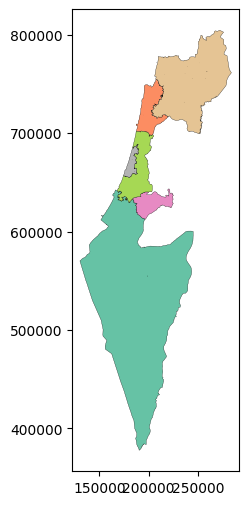

In [125]:
districts.plot(column='Machoz', cmap='Set2', edgecolor='black', linewidth=0.2);

Again, the `'Muni_Heb'` and `'area_km2'` attributes reflect the first value for each district and are no longer correct. We can either edit them manually (see {ref}`dissolving-by-town-name`), or use `aggfunc` other than `'first'` (see below, {ref}`using-aggfunc`).

(using-aggfunc)=
### Using `aggfunc`

As an example of using other `aggfunc` options, let's re-calculate the `'Machoz'` polygons, this time using `aggfunc='sum'`:

In [126]:
districts = towns[['Machoz', 'area_km2', 'geometry']] \
    .dissolve(by='Machoz', aggfunc='sum') \
    .reset_index()
districts

Machoz                            geometry      area_km2
0     דרום  POLYGON Z ((214342.276 467536.8...  14475.358699
1     חיפה  MULTIPOLYGON Z (((205341.469 70...    896.318958
2  ירושלים  POLYGON Z ((210711.062 624658.6...    653.586849
3     מרכז  POLYGON Z ((176923.016 632550.2...   1262.089183
4     צפון  MULTIPOLYGON Z (((222775.875 71...   4649.448773
5  תל אביב  MULTIPOLYGON Z (((177311.878 65...    229.190495

This time, in the dissolved result, the `'area_km2'` column contains the *summed* area of all geometries in each group, which is the correct value. Compare with the above result, where the column contained the value of just the first geometry, which is incorrect.

(geopandas-geometric-relations)=
## Boolean methods (`geopandas`)

The `geopandas` package contains numerous functions to evaluate boolean relations between geometries. For instance, in the next example, we are interested to examine which railway stations intersect with the area of Beer-Sheva, and then to subset those stations. To do that, in technical terms, we need to evaluate whether each geometry in the `stations` layer intersects with a the specific geometry (Beer-Sheva) in the `towns` layer.

`geopandas` defines boolean methods of the same name ({numref}`geopandas-boolean-methods`) as the analogous `shapely` methods we learned about earlier (see {ref}`shapely-boolean-methods`). The difference is that the `shapely` methods returns a single boolean value, indicating whether two `shapely` geometries satisfy the given relation (see {ref}`shapely-boolean-functions`), while the `geopandas` version returns a boolean `Series` with pairwise results. The `geopandas` methods have two modes of operation, same as for the distance and geometry-generating methods we've seen earlier (see {numref}`geopandas-pairwise`):

* Many-to-One--- when the "second" argument is a `shapely` geometry ({numref}`geopandas-pairwise`, left)
* Pairwise---when the "second" argument is a `GeoSeries` ({numref}`geopandas-pairwise`, right)

```{table} <code>geopandas</code> boolean methods
:name: geopandas-boolean-methods

| Method | Meaning |
|:---:|:---:|
| [`.contains`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.contains.html) | Contains |
| [`.covered_by`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.covered_by.html) | Covered by |
| [`.covers`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.covers.html) | Covers |
| [`.crosses`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.crosses.html) | Crosses |
| [`.disjoint`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.disjoint.html) | Disjoint |
| [`.geom_equals`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.geom_equals.html) | Equals |
| [`.geom_equals_exact`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.geom_equals_exact.html) | Exactly equal |
| [`.geom_almost_equals`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.geom_almost_equals.html) | Almost equal |
| [`.intersects`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.intersects.html) | Intersects |
| [`.overlaps`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.overlaps.html) | Overlaps |
| [`.touches`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.touches.html) | Touches |
| [`.within`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.within.html) | Within |
```

Of the various methods, [`.intersects`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.intersects.html) is the most useful one. Again, we are going to demonstrate the simpler "many-to-one" mode, where we have a `GeoSeries` or a `GeoDataFrame` on the one hand, and an individual `shapely` geometry on the other hand. 

First of all, let us subset the `towns` layer to retain just the Beer-Sheva `shapely` polygon, as follows:

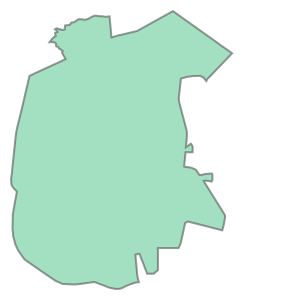

In [127]:
pol = towns[towns['Muni_Heb'] == 'באר שבע']
pol = pol.geometry.iloc[0]
pol

Now, let's evaluate the intersection between each geometry in `stations`, on the one hand, and the individual `pol` geometry, on the other hand, using the `.intersects` method:

In [128]:
sel = stations.intersects(pol)
sel

0     False
1     False
2     False
3     False
4     False
      ...  
58    False
59     True
60    False
61    False
62    False
Length: 63, dtype: bool

The result `sel` is a boolean `Series`, indicating for each `stations` feature whether it intersects with the Beer-Sheva polygon.

```{admonition} Exercise 09-e
:class: important
* How can we check how many of the `stations` features intersect with the polygon, i.e., to count the number of `True` values in the `sel` series?
```

Using the boolean `Series` from the previous code section, we can subset (see {ref}`dataframe-filtering`) the railway stations that are within Beer-Sheva:

In [129]:
stations[sel]

STAT_NAMEH  OFF_7_DAY                       geometry  \
41        באר שבע מרכז      174.0   POINT (180768.91 572476.735)   
59  באר שבע אוניברסיטה      130.0  POINT (181813.614 574550.411)   

    nearest_seg_dist              nearest_seg_name  
41         34.113422  באר שבע אוניברסיטה - באר שבע  
59          7.540327  באר שבע צפון - באר שבע אוניב

Here is the plot of the resulting `stations` subset, on top of the town polygon used for filtering them:

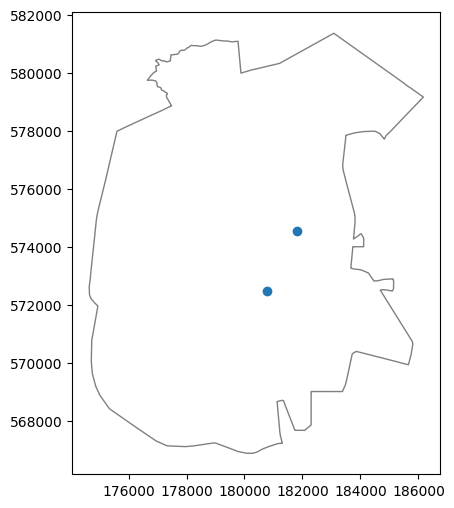

In [130]:
base = gpd.GeoSeries(pol).plot(color='none', edgecolor='grey')
stations[sel].plot(ax=base);

Another common scenarion is when we want to subset by location based on an entire layer, rather than one specific geometry. For example, suppose that we want to select all towns that have at least one railway station. To do that, we can "dissolve" the `stations` layer using `.union_all`: 

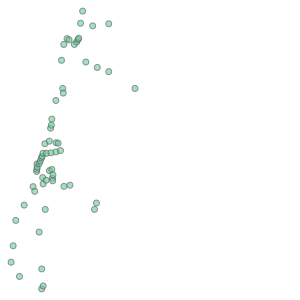

In [131]:
pnt = stations.union_all()
pnt

and then use it for subsetting through `.intersects`:

In [132]:
towns1 = towns[towns.intersects(pnt)]
towns1

Muni_Heb                            geometry   Machoz    area_km2
4           אופקים  POLYGON Z ((164806.146 577898.8...     דרום   16.352399
16           אשדוד  POLYGON Z ((168551.19 631688.68...     דרום   63.921935
18          אשקלון  POLYGON Z ((161804.408 617717.9...     דרום   52.318022
21        באר יעקב  MULTIPOLYGON Z (((186344.49 651...     מרכז    9.460773
22         באר שבע  POLYGON Z ((175342.311 568405.3...     דרום  117.393493
..             ...                                 ...      ...         ...
261         רחובות  POLYGON Z ((182522.016 647565.9...     מרכז   23.757677
264           רמלה  POLYGON Z ((187465.305 649941.0...     מרכז   13.388352
272        שדות דן  POLYGON Z ((185799.044 652407.8...     מרכז   29.346022
278       שער הנגב  POLYGON Z ((173176.919 603057.4...     דרום  176.157893
281  תל אביב - יפו  POLYGON Z ((186077.611 668970.3...  תל אביב   57.096655

[40 rows x 4 columns]

The following figure shows the selected towns:

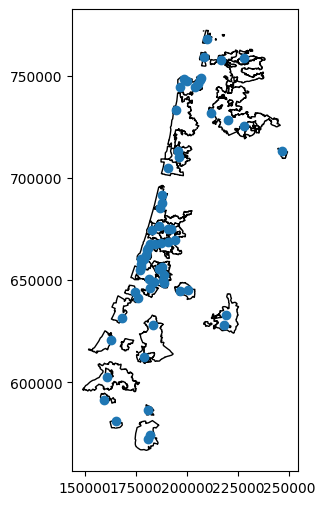

In [133]:
base = towns1.plot(color='none', edgecolor='black')
stations.plot(ax=base);

(geopandas-spatial-join)=
## Spatial join

(ordinary-spatial-join)=
### Ordinary spatial join

*Spatial join* merges two spatial layers, in the same sense that an ordinary (i.e., non-spatial) join merges two tables (see {ref}`pandas-joining-tables`). The difference is that matching rows (i.e., features) are not determined according to identical values in a shared column. Instead, they are determined based on spatial relations. Typically, spatial join is based on the *intersection* relation (see {ref}`geopandas-geometric-relations`), meaning that we are joining attributes of feature(s) from the second layer, which intersect with the given feature in the first layer. 

In `geopandas`, spatial join is done using the [`gpd.sjoin`](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html) ("spatial join") function. The `gpd.sjoin` function takes the following arguments:

* `left_df`---The first ("left") layer
* `right_df`---The second ("right") layer
* `how`---The type of join, one of: 
    * `'inner'` (the default)
    * `'left'` 
    * `'right'`
* `predicate`---The spatial relation to evaluate when looking for a match, one of: 
    * `'intersects'` (the default) 
    * `'contains'` 
    * `'crosses'` 
    * `'overlaps'` 
    * `'touches'` 
    * `'within'`

You may notice similarities with the `pd.merge` function for ordinary (non-spatial) join (see {ref}`pandas-joining-tables`). Namely, three of the four parameters are the same: the two tables/layers, and the `how` argument for join type. The difference is just the method for evaluating the matching rows/features:

* In an *ordinary* join, matching rows are determined based on identical values in common column(s), specified using the `on` argument of `pd.merge`
* In a *spatial* join, matching features are determined based on spatial relations, such as whether the two features intersect or not, whereas the type of relation is specified using the `predicate` argument of `gpd.sjoin`

For example, the following spatial join operation reveals, for each railway station, which town it intersects with (i.e., located within). We also limit the input layers to just one attribute each, to see more clearly what is going on:

In [134]:
gpd.sjoin(
    stations[['STAT_NAMEH', 'geometry']], 
    towns[['Muni_Heb', 'geometry']], 
    how='left'
)

STAT_NAMEH                       geometry  index_right  \
0   ראשון לציון משה דיין  POINT (177206.094 655059.936)          258   
1        קרית ספיר נתניה  POINT (187592.123 687587.598)          213   
2              ת"א השלום    POINT (180621.94 664537.21)          281   
3                  שדרות  POINT (160722.849 602798.889)          278   
4                   רמלה    POINT (188508.91 648466.87)          264   
..                   ...                            ...          ...   
58    מגדל העמק כפר ברוך  POINT (219851.931 728164.825)          227   
59    באר שבע אוניברסיטה  POINT (181813.614 574550.411)           22   
60          חיפה בת גלים    POINT (198610.01 748443.79)           81   
61                   לוד  POINT (188315.977 650289.373)          123   
62                 נהריה    POINT (209570.59 767769.22)          204   

         Muni_Heb  
0     ראשון לציון  
1           נתניה  
2   תל אביב - יפו  
3        שער הנגב  
4            רמלה  
..            ...  
58     עמק יזרעאל  
59        באר שבע  
60           חיפה  
61            לוד  
62          נהריה  

[63 rows x 4 columns]

The spatial join result contains the attributes and geometry of the *left* layer, plus joined attributes and indices (`'index_right'`) of the *right* layer. In this case, we have:

* the `'STAT_NAMEH'`, `'geometry'` columns from the "left" `stations` layer, and 
* the `'index_right'` and `'Muni_Eng'` columns joined from the "right" `towns` layer.

For example, the first feature in the spatial join result reveals that the `'ראשון לציון משה דיין'` station is located in the town `'ראשון לציון'`.

As another, more complicated, example, the following spatial join might be a first attempt to can check which railway segment goes through each railway station: 

In [135]:
gpd.sjoin(
    stations[['STAT_NAMEH', 'geometry']], 
    rail, 
    how='left'
)

STAT_NAMEH                       geometry  index_right SEGMENT  \
0   ראשון לציון משה דיין  POINT (177206.094 655059.936)          NaN     NaN   
1        קרית ספיר נתניה  POINT (187592.123 687587.598)          NaN     NaN   
2              ת"א השלום    POINT (180621.94 664537.21)          NaN     NaN   
3                  שדרות  POINT (160722.849 602798.889)          NaN     NaN   
4                   רמלה    POINT (188508.91 648466.87)          NaN     NaN   
..                   ...                            ...          ...     ...   
58    מגדל העמק כפר ברוך  POINT (219851.931 728164.825)          NaN     NaN   
59    באר שבע אוניברסיטה  POINT (181813.614 574550.411)          NaN     NaN   
60          חיפה בת גלים    POINT (198610.01 748443.79)          NaN     NaN   
61                   לוד  POINT (188315.977 650289.373)          NaN     NaN   
62                 נהריה    POINT (209570.59 767769.22)          NaN     NaN   

    length_km  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
..        ...  
58        NaN  
59        NaN  
60        NaN  
61        NaN  
62        NaN  

[63 rows x 5 columns]

In this case, we see that none, or at least the first and last few, stations, had a match. This means that none of the lines *precisely* intersect with the station points.

One way to overcome this is to use nearest-neighbor join (see {ref}`nearest-neighbor-join`). Another option is to use a buffered version of the stations, say with a 100 $m$ buffer. In this case, we join the attributes of the segments that are *within* a 100 $m$ distance from each station:

In [136]:
stations1 = stations.copy()
stations1.geometry = stations1.buffer(100)
stations1[['STAT_NAMEH', 'geometry']]

STAT_NAMEH                            geometry
0   ראשון לציון משה דיין  POLYGON ((177306.094 655059.936...
1        קרית ספיר נתניה  POLYGON ((187692.123 687587.598...
2              ת"א השלום  POLYGON ((180721.94 664537.21, ...
3                  שדרות  POLYGON ((160822.849 602798.889...
4                   רמלה  POLYGON ((188608.91 648466.87, ...
..                   ...                                 ...
58    מגדל העמק כפר ברוך  POLYGON ((219951.931 728164.825...
59    באר שבע אוניברסיטה  POLYGON ((181913.614 574550.411...
60          חיפה בת גלים  POLYGON ((198710.01 748443.79, ...
61                   לוד  POLYGON ((188415.977 650289.373...
62                 נהריה  POLYGON ((209670.59 767769.22, ...

[63 rows x 2 columns]

Then, we join the *buffered* `stations1` with the `rail` layer:

In [137]:
gpd.sjoin(
    stations1[['STAT_NAMEH', 'geometry']], 
    rail, 
    how='left'
)

STAT_NAMEH                            geometry  index_right  \
0   ראשון לציון משה דיין  POLYGON ((177306.094 655059.936...         81.0   
0   ראשון לציון משה דיין  POLYGON ((177306.094 655059.936...         22.0   
1        קרית ספיר נתניה  POLYGON ((187692.123 687587.598...        100.0   
2              ת"א השלום  POLYGON ((180721.94 664537.21, ...         79.0   
2              ת"א השלום  POLYGON ((180721.94 664537.21, ...         57.0   
..                   ...                                 ...          ...   
60          חיפה בת גלים  POLYGON ((198710.01 748443.79, ...        153.0   
60          חיפה בת גלים  POLYGON ((198710.01 748443.79, ...        193.0   
61                   לוד  POLYGON ((188415.977 650289.373...         77.0   
61                   לוד  POLYGON ((188415.977 650289.373...        198.0   
62                 נהריה  POLYGON ((209670.59 767769.22, ...          NaN   

                         SEGMENT  length_km  
0              משה דיין-חולות_82   1.851570  
0            משה דיין-קוממיות_23   1.477394  
1   נתניה מכללה - נתניה ספיר_101   1.417325  
2            יצחק שדה - השלום_80   1.009135  
2         סבידור מרכז - השלום_58   1.286116  
..                           ...        ...  
60        חוף כרמל - בת גלים_156   6.121700  
60          השמונה - בת גלים_197   1.644544  
61                 לוד - רמלה_78   1.339807  
61             לוד-רמלה מערב_203   1.412130  
62                           NaN        NaN  

[113 rows x 5 columns]

In this case, there are even stations with more than one matching line (e.g., `'ראשון לציון משה דיין'`), because there can be more than one railway segment passing through a radius of 100 $m$ of a railway station. However, other stations still had zero matches (e.g., `'נהריה'`). This leads us to the second option of dealing with the situation, the nearest neighbor join (see below, {ref}`nearest-neighbor-join`).

```{admonition} Exercise 09-f
:class: important
* Note that the last station (`'נהריה'`) has "No Data" in the segment name column (`'SEGMENT'`). Can you explain why?
```

(nearest-neighbor-join)=
### Nearest neighbor join

In addition to spatial join based on "ordinary" relations such as intersection (see {ref}`ordinary-spatial-join`), the `geopandas` package also has a [`gpd.sjoin_nearest`](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin_nearest.html) function for spatial join based on *nearest neighbors*. It works similarly to `gpd.sjoin`, but matches are determined based on shortest pairwise distance. 

The following expression joins the nearest railway line attributes (including segment name, `'SEGMENT'`) and specifies the distances in the `'dist'` column as requested using the `distance_col='dist'` argument:

In [138]:
stations = gpd.sjoin_nearest(
    stations[['STAT_NAMEH', 'nearest_seg_dist', 'nearest_seg_name', 'geometry']], 
    rail[['SEGMENT', 'geometry']], 
    distance_col='dist'
)
stations

STAT_NAMEH  nearest_seg_dist              nearest_seg_name  \
0   ראשון לציון משה דיין         13.440327           משה דיין-קוממיות_23   
1        קרית ספיר נתניה          4.932094  נתניה מכללה - נתניה ספיר_101   
2              ת"א השלום         16.180832        סבידור מרכז - השלום_58   
3                  שדרות         64.381044            שדרות-יד מרדכי_134   
4                   רמלה          2.941401                 לוד - רמלה_88   
..                   ...               ...                           ...   
58    מגדל העמק כפר ברוך         56.102377          עפולה - כפר ברוך_155   
59    באר שבע אוניברסיטה          7.540327  באר שבע צפון - באר שבע אוניב   
60          חיפה בת גלים         44.130049        חוף כרמל - בת גלים_156   
61                   לוד         22.556829                 לוד - רמלה_78   
62                 נהריה        115.502833                נהריה - עכו_13   

                         geometry  index_right                       SEGMENT  \
0   POINT (177206.094 655059.936)           22           משה דיין-קוממיות_23   
1   POINT (187592.123 687587.598)          100  נתניה מכללה - נתניה ספיר_101   
2     POINT (180621.94 664537.21)           57        סבידור מרכז - השלום_58   
3   POINT (160722.849 602798.889)          131            שדרות-יד מרדכי_134   
4     POINT (188508.91 648466.87)           87                 לוד - רמלה_88   
..                            ...          ...                           ...   
58  POINT (219851.931 728164.825)          152          עפולה - כפר ברוך_155   
59  POINT (181813.614 574550.411)          205  באר שבע צפון - באר שבע אוניב   
60    POINT (198610.01 748443.79)          153        חוף כרמל - בת גלים_156   
61  POINT (188315.977 650289.373)           77                 לוד - רמלה_78   
62    POINT (209570.59 767769.22)           12                נהריה - עכו_13   

          dist  
0    13.440327  
1     4.932094  
2    16.180832  
3    64.381044  
4     2.941401  
..         ...  
58   56.102377  
59    7.540327  
60   44.130049  
61   22.556829  
62  115.502833  

[63 rows x 7 columns]

This time, we get exactly one matching `rail` segment per `stations` point. In addition to the segment name (`'SEGMENT'`), the distance to the matched nearest segment is documented in the `'dist'` column. As you can see, the values in these two columns are identical to the `'nearest_seg_name'` and `'nearest_seg_dist'` columns, respectively, which we calculated earlier using a "manual" approach (see {ref}`nearest-neighbors`):

In [139]:
(stations['nearest_seg_name'] == stations['SEGMENT']).all()

np.True_

In [140]:
(stations['nearest_seg_dist'] == stations['dist']).all()

np.True_

```{note}
For more information, see the `gpd.sjoin_nearest` function documentation: <https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin_nearest.html>.
```

(exercise-geopandas2)=
## More exercises

```{admonition} Exercise 09-g
:class: important

* Read the towns (`'muni_il.shp'`) layer (see {ref}`geopandas2-sample-data`)
* Aggregate it according to the `'Machoz'` column to dissolve the towns into district polygons (see {ref}`dissolving-by-district`)
* Calculate the number of neighbors, i.e., districts it intersects with excluding self, that each district has. 
* Plot the result ({numref}`exercise-09-g`).
* Advanced: display labels with the number of neighbors per district ({numref}`exercise-09-g`), by adapting this StackOverflow [answer](https://stackoverflow.com/questions/38899190/geopandas-label-polygons#answer-42214156).
* Hint: 
    * Join the layer with itself, based on 'intersection', to join each town with all of its neighbors, then use aggregation to calculate the sum of joined towns per town. You can create a `'count'` variable for each town, equal to `1`, then sum it when calculating the number of neighbors.
    * Subtract `1` to get the number of intersections excluding intersection with self, i.e., the number of neighbors.
```

```{glue:figure} exercise-09-g
---
name: exercise-09-g
---
Solution of exercise-09-g: Neighbor count per town
```

```{admonition} Exercise 09-h
:class: important
* Calculate the total population size in a 1 $km$ buffer around each railway station in `'RAIL_STAT_ONOFF_MONTH.shp'`, according to the population data in `'statisticalareas_demography2019.gdb'` (`'Pop_Total'`=total population).
* Sort the table, to see which stations are situated in the most dense and sparse areas ({numref}`exercise-09-h`).
* Go through the following steps:
    * Import both layers into `GeoDataFrame` objects
    * Calculate the *area* of each statistical area polygon
    * Fill the missing population estimates (in the `'Pop_Total'` column) with zeros
    * Create a buffer of 1 $km$ around the station points
    * Calculate a layer of pairwise intersections between the buffers and the statistical areas
    * Calculate the area of each *intersection*
    * Calculate the population count of each *intersection*. To do that, multiply the statistical area population count column (`'Pop_Total'`) by the ratio between the intersection area, and the original total area of that statistical area (which you calculated in the second step earlier). 
    * Aggregate the layer by rail station name, to calculate the total population count per 1 $km$ buffer around a station
    * Sort the layer by population counts, to see which stations are situated in the most dense and sparse areas
```

```{glue:figure} exercise-09-h
---
name: exercise-09-h
---
Solution of exercise-09-h: Railway stations with largest and smallest population counts in a 1 km buffer
```

```{admonition} Exercise 09-i
:class: important
* Read the following vector layers (see {ref}`geopandas2-sample-data`):
    * `'muni_il.shp'`---Towns
    * `'RAIL_STRATEGIC.shp'`---Railway lines
* Aggregate the towns layer according to the `'Muni_Heb'` column to dissolve the separate polygons per town (see {ref}`geopandas-dissolve`)
* Subset only the *active* railway lines, i.e., where the value in the `'ISACTIVE'` column is equal to `'פעיל'` (see {ref}`subsetting-by-attributes`)
* Subset the town polygons that a railway line goes through
* Plot the resulting subset of towns and the active railway lines together ({numref}`exercise-09-i`)
```

```{glue:figure} exercise-09-i
---
name: exercise-09-i
---
Solution of exercise-09-i: Towns (grey polygons) intersecting with active railway lines (black lines)
```

```{admonition} Exercise 09-j
:class: important
* Read the following vector layers (see {ref}`geopandas2-sample-data`):
    * `'muni_il.shp'`---Towns
    * `'RAIL_STRATEGIC.shp'`---Railway lines
* Aggregate the towns layer according to the `'Muni_Heb'` column to dissolve the separate polygons per town (see {ref}`geopandas-dissolve`)
* Subset only the *active* railway lines, i.e., where the value in the `'ISACTIVE'` column is equal to `'פעיל'` (see {ref}`subsetting-by-attributes`)
* Calculate and plot the density ($km / km^2$) of railway lines per town ({numref}`exercise-09-j1`)
* Print the information for five towns with the highest densities ({numref}`exercise-09-j2`)
```

```{glue:figure} exercise-09-j1
---
name: exercise-09-j1
---
Solution of exercise-09-j1: Density of active railway lines (black lines) in each town
```

```{glue:figure} exercise-09-j2
---
name: exercise-09-j2
---
Solution of exercise-09-j2: The five towns with the highest railway line densities
```

## Exercise solutions

In [141]:
from myst_nb import glue

### Exercise 09-b

In [142]:
import geopandas as gpd
towns = gpd.read_file('data/muni_il.shp', encoding='utf-8')
towns = towns[['Muni_Heb', 'geometry']]
towns['area'] = towns.area
towns1 = towns.sort_values('area')
towns1['Muni_Heb'].iloc[0]

'ללא שיפוט - אזור נחל ארבל'

In [143]:
towns1['Muni_Heb'].iloc[towns1.shape[0]-1]

'רמת נגב'

### Exercise 09-c

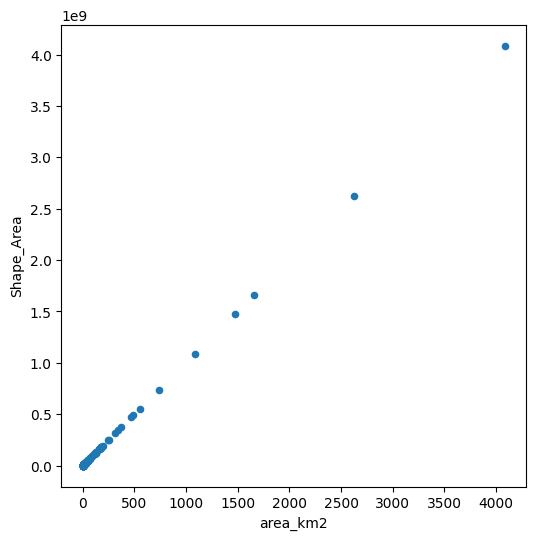

In [144]:
import geopandas as gpd
towns = gpd.read_file('data/muni_il.shp', encoding='utf-8')
towns = towns[['Muni_Heb', 'Shape_Area', 'geometry']]
towns['area_km2'] = towns.area / 1000**2
towns.plot.scatter('area_km2', 'Shape_Area');

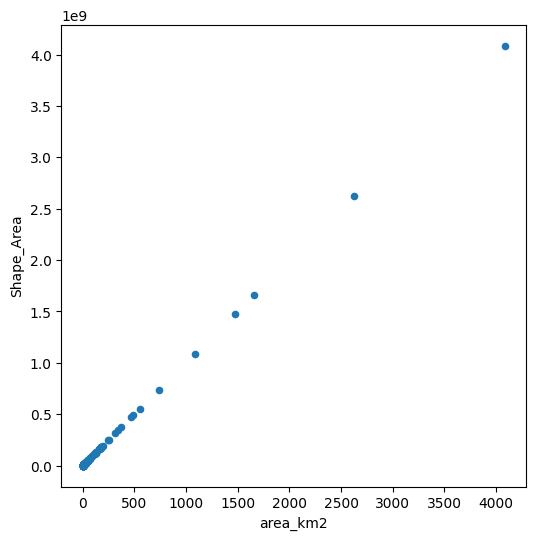

In [145]:
plot = towns.plot.scatter('area_km2', 'Shape_Area');
fig = plot.get_figure()
glue('exercise-09-c', fig, display=False)

### Exercise 09-g

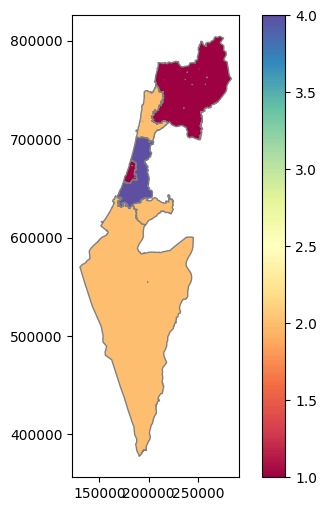

In [146]:
import geopandas as gpd
# Read data & subset columns
towns = gpd.read_file('data/muni_il.shp', encoding='utf-8')
towns = towns[['Machoz', 'geometry']]
# Dissolve
districts = towns.dissolve(by='Machoz').reset_index()
# Add 'count' variable
districts['count'] = 1
# Spatial join with self
districts = gpd.sjoin(
    districts[['Machoz', 'geometry']], 
    districts[['count', 'geometry']], 
    how='left', 
    predicate='intersects'
)
districts = districts.drop('index_right', axis=1)
# Aggregate
districts = districts.dissolve(by='Machoz', aggfunc='sum')
# Subtract 1 (self)
districts['count'] = districts['count'] - 1
# Plot
districts.plot(column='count', cmap='Spectral', edgecolor='grey', legend=True);

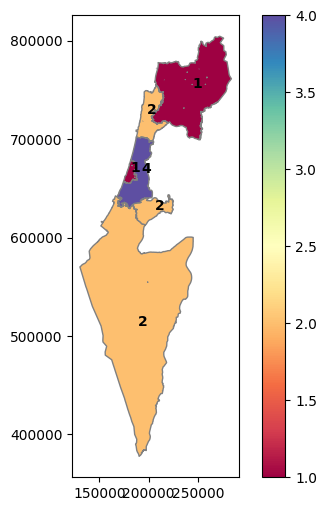

In [147]:
plot = districts.plot(column='count', cmap='Spectral', edgecolor='grey', legend=True)
districts.apply(lambda x: plot.annotate(text=x['count'], xy=x.geometry.representative_point().coords[0], weight='bold'), axis=1)
fig = plot.get_figure()
glue('exercise-09-g', fig, display=False)

### Exercise 09-h

In [148]:
import pandas as pd
import geopandas as gpd
# Read & subset columns
stations = gpd.read_file('data/RAIL_STAT_ONOFF_MONTH.shp')
stat = gpd.read_file('data/statisticalareas_demography2019.gdb')
stations = stations[['STAT_NAMEH', 'geometry']]
stat = stat[['SHEM_YISHUV', 'Pop_Total', 'geometry']]
# Calculate area
stat['area'] = stat.area
# Replace "No Data" population with 0
stat['Pop_Total'] = stat['Pop_Total'].fillna(0)
# Buffer stations
stations.geometry = stations.buffer(1000)
# Intersect
stations = gpd.overlay(stations, stat, how="intersection")
# Calculate population per polygon
stations['area1'] = stations.area
stations['prop'] = stations['area1'] / stations['area']
stations['pop1'] = stations['Pop_Total'] * stations['prop']
# Dissolve
stations = stations[['STAT_NAMEH', 'pop1', 'geometry']].dissolve(by='STAT_NAMEH', aggfunc='sum').reset_index()
# Sort
stations = stations.sort_values(by='pop1', ascending=False)
stations

STAT_NAMEH                            geometry          pop1
11        בת ים יוספטל  POLYGON ((177152.75 657153.746,...  55761.058635
24   ירושלים יצחק נבון  POLYGON ((218650.757 632087.423...  46441.448009
62     ת"א סבידור מרכז  POLYGON ((180306.847 665089.717...  39493.940946
16       חולון וולפסון  POLYGON ((176806.558 659551.427...  35295.776253
48         קרית מוצקין  POLYGON ((206654.795 747716.12,...  35148.940155
..                 ...                                 ...           ...
32  מגדל העמק כפר ברוך  POLYGON ((218894.991 727874.541...     29.732200
23    יקנעם כפר יהושוע  POLYGON ((212300.18 731084.998,...      0.000000
17         חוצות המפרץ  POLYGON ((205604.63 745103.145,...      0.000000
42        פאתי מודיעין  POLYGON ((197394.885 644447.483...      0.000000
49     קרית מלאכי יואב  POLYGON ((184266.43 628244.915,...      0.000000

[63 rows x 3 columns]

In [149]:
glue('exercise-09-h', stations)

STAT_NAMEH                            geometry          pop1
11        בת ים יוספטל  POLYGON ((177152.75 657153.746,...  55761.058635
24   ירושלים יצחק נבון  POLYGON ((218650.757 632087.423...  46441.448009
62     ת"א סבידור מרכז  POLYGON ((180306.847 665089.717...  39493.940946
16       חולון וולפסון  POLYGON ((176806.558 659551.427...  35295.776253
48         קרית מוצקין  POLYGON ((206654.795 747716.12,...  35148.940155
..                 ...                                 ...           ...
32  מגדל העמק כפר ברוך  POLYGON ((218894.991 727874.541...     29.732200
23    יקנעם כפר יהושוע  POLYGON ((212300.18 731084.998,...      0.000000
17         חוצות המפרץ  POLYGON ((205604.63 745103.145,...      0.000000
42        פאתי מודיעין  POLYGON ((197394.885 644447.483...      0.000000
49     קרית מלאכי יואב  POLYGON ((184266.43 628244.915,...      0.000000

[63 rows x 3 columns]

### Exercise 09-i

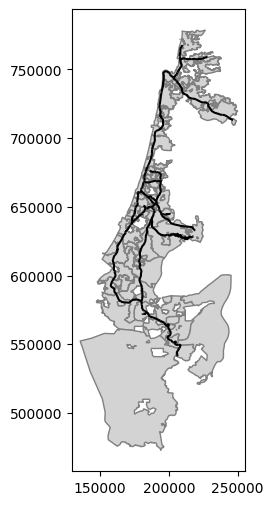

In [150]:
import geopandas as gpd
# Read & subset columns
towns = gpd.read_file('data/muni_il.shp', encoding='utf-8')
rail = gpd.read_file('data/RAIL_STRATEGIC.shp')
towns = towns[['Muni_Heb', 'geometry']]
rail = rail[['ISACTIVE', 'geometry']]
# Subset railways
sel = rail['ISACTIVE'] == 'פעיל'
rail = rail[sel]
# Dissolve towns
towns = towns.dissolve(by='Muni_Heb').reset_index()
# Union railway lines
rail1 = rail.union_all()
# Subset towns
sel = towns.intersects(rail1)
towns = towns[sel]
# Plot
base = towns.plot(color='lightgrey', edgecolor='grey')
rail.plot(ax=base, color='black');

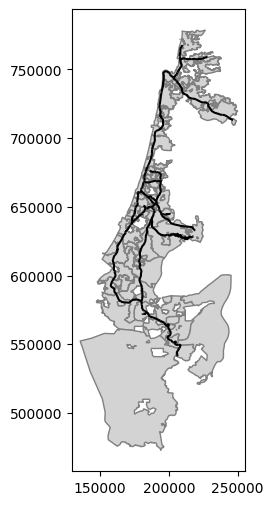

In [151]:
base = towns.plot(color='lightgrey', edgecolor='grey')
rail.plot(ax=base, color='black');
fig = base.get_figure()
glue('exercise-09-i', fig, display=False)

### Exercise 09-j

In [152]:
import pandas as pd
import geopandas as gpd
# Read & subset columns
towns = gpd.read_file('data/muni_il.shp', encoding='utf-8')
rail = gpd.read_file('data/RAIL_STRATEGIC.shp')
towns = towns[['Muni_Heb', 'geometry']]
rail = rail[['ISACTIVE', 'geometry']]
# Subset railways
sel = rail['ISACTIVE'] == 'פעיל'
rail = rail[sel]
# Dissolve towns
towns = towns.dissolve(by='Muni_Heb').reset_index()
# Union railway lines
rail1 = rail.union_all()
rail1 = gpd.GeoSeries(rail1, crs=rail.crs)
rail1 = gpd.GeoDataFrame(geometry=rail1)
# Calculate intersections
rail2 = gpd.overlay(rail1, towns)
# Calculate density
rail2['length'] = rail2.length
rail2 = rail2.drop(columns='geometry')
rail2 = pd.DataFrame(rail2)
towns = pd.merge(towns, rail2, on='Muni_Heb', how='left')
towns['length'] = towns['length'].fillna(0)
towns['area'] = towns.area
towns['density'] = towns['length'] / towns['area']

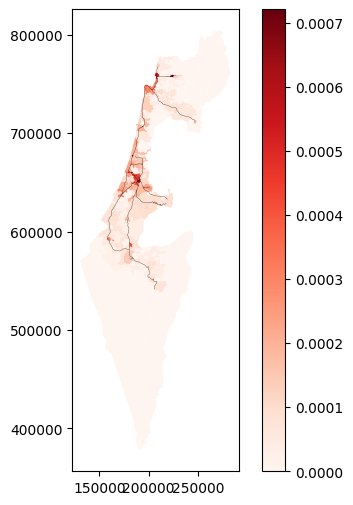

In [153]:
base = towns.plot(column='density', edgecolor='none', legend=True, cmap='Reds')
rail.plot(ax=base, color='black', linewidth=0.2)
fig = base.get_figure()
glue('exercise-09-j1', fig, display=False)

In [154]:
towns1 = towns.sort_values(by='density', ascending=False).iloc[:5]

In [155]:
glue('exercise-09-j2', towns1)

Muni_Heb                            geometry  \
178                        מג'ד אל כרום  POLYGON Z ((217664.43 757558.83...   
123                                 לוד  POLYGON Z ((190500.083 653157.0...   
118                          כפר שמריהו  POLYGON Z ((183034.588 677872.3...   
160  ללא שיפוט - אזור מקווה ישראל - ...  POLYGON Z ((183642.638 658968.6...   
223                                 עכו  POLYGON Z ((210673.625 758793.3...   

          length          area   density  
178  6708.740078  9.306777e+06  0.000721  
123  9380.882915  1.478579e+07  0.000634  
118  1667.309175  2.728429e+06  0.000611  
160  4454.321971  7.645018e+06  0.000583  
223  9865.824430  1.809508e+07  0.000545